# Data Mining Project: TMDB Box Office Prediction
#### source: https://www.kaggle.com/c/tmdb-box-office-prediction

### Group 12
#### Member: Ran He / Renlu Zhang /Chen Gao / Mengqi Li

In [1]:
import pandas as pd
import numpy as np
import ast
from pandas.io.json import json_normalize
import json
import h2o.targetencoder
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.corpus import stopwords ##import stopwords list
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator

### Part 1 Load Data

In [394]:
box_train = pd.read_csv('box_train.csv', index_col = 0)
box_test = pd.read_csv('box_test.csv', index_col = 0)

In [216]:
box_train.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the Internet,"" is shot by ...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel...","[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directin...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id':...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and on her way to Genovi...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'},...","[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directin...",95149435
3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, a talented young dru...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, ...","[{'cast_id': 5, 'character': 'Andrew Neimann', 'credit_id': '52fe4...","[{'credit_id': '54d5356ec3a3683ba0000039', 'department': 'Producti...",13092000
4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata from London to find ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywoo...","[{'cast_id': 1, 'character': 'Vidya Bagchi', 'credit_id': '52fe487...","[{'credit_id': '52fe48779251416c9108d6eb', 'department': 'Directin...",16000000
5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national swimmer who finds him...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'credit_id': '52fe464b925...","[{'credit_id': '52fe464b9251416c75073b43', 'department': 'Directin...",3923970


In [217]:
box_train.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


In [218]:
box_test.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
id,,,,,,,,,,,,,,,,,,,,,
3001,"[{'id': 34055, 'name': 'Pokémon Collection', 'poster_path': '/j5te...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'},...",http://www.pokemon.com/us/movies/movie-pokemon-the-rise-of-darkrai...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newcomer Dawn) arrive at...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket ...","[{'cast_id': 3, 'character': 'Tonio', 'credit_id': '52fe44e7c3a368...","[{'credit_id': '52fe44e7c3a368484e03d683', 'department': 'Directin..."
3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fictio...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size because of an alien encoun...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951, 'name': 'alien'}, {...","[{'cast_id': 2, 'character': 'Nancy Fowler Archer', 'credit_id': '...","[{'credit_id': '55807805c3a3685b1300060b', 'department': 'Editing'..."
3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when the love of his lif...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673, 'name': 'love'}, {'...","[{'cast_id': 11, 'character': 'Maggie', 'credit_id': '52fe4330c3a3...","[{'credit_id': '52fe4330c3a36847f8041367', 'department': 'Directin..."
3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}, {'id':...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and Simon on a journey to...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso_3166_1': 'FR', 'nam...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'iso_639_1': 'ar', 'nam...",Released,The search began at the opening of their mother's will.,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'name': 'middle east'}...","[{'cast_id': 6, 'character': 'Nawal', 'credit_id': '52fe470ac3a368...","[{'credit_id': '56478092c3a36826140043af', 'department': 'Visual E..."
3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'name': 'Documentary'}]",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget pornographic film w...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollars. The government di...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'name': '1970s'}, {'id':...","[{'cast_id': 1, 'character': 'Narrator (voice)', 'credit_id': '52f...","[{'credit_id': '52fe44ce9251416c75041967', 'department': 'Producti..."


In [219]:
box_test.describe()

,budget,popularity,runtime
count,4.398000e+03,4398.000000,4394.000000
mean,2.264929e+07,8.550230,107.622212
std,3.689991e+07,12.209014,21.058290
min,0.000000e+00,0.000001,0.000000
25%,0.000000e+00,3.895186,94.000000
50%,7.450000e+06,7.482241,104.000000
75%,2.800000e+07,10.938524,118.000000
max,2.600000e+08,547.488298,320.000000


### Part 2 Explanatory Data Analysis

Firstly, we try to find the column name in each data set, how many missing value are there and how many unique values in each column.

In [220]:
# Check the number of missing values, duplicated value in each variable of training sample
for col in box_train.columns:
    missingvallue = box_train[col].isna().sum()
    withvalue = len(box_train)-box_train[col].isna().sum()
    uniquevalue = box_train[col].nunique()
    coltype = box_train[col].dtypes
    if withvalue == uniquevalue:
        deplitedvalue = 'no duplicated value'
    else:
        deplitedvalue = 'has duplicated value'
    print(col, '/', missingvallue, '/', withvalue, '/',uniquevalue, '/',deplitedvalue,'/',coltype)

belongs_to_collection / 2396 / 604 / 422 / has duplicated value / object
budget / 0 / 3000 / 406 / has duplicated value / int64
genres / 7 / 2993 / 872 / has duplicated value / object
homepage / 2054 / 946 / 941 / has duplicated value / object
imdb_id / 0 / 3000 / 3000 / no duplicated value / object
original_language / 0 / 3000 / 36 / has duplicated value / object
original_title / 0 / 3000 / 2975 / has duplicated value / object
overview / 8 / 2992 / 2992 / no duplicated value / object
popularity / 0 / 3000 / 2999 / has duplicated value / float64
poster_path / 1 / 2999 / 2999 / no duplicated value / object
production_companies / 156 / 2844 / 2383 / has duplicated value / object
production_countries / 55 / 2945 / 321 / has duplicated value / object
release_date / 0 / 3000 / 2398 / has duplicated value / object
runtime / 2 / 2998 / 139 / has duplicated value / float64
spoken_languages / 20 / 2980 / 401 / has duplicated value / object
status / 0 / 3000 / 2 / has duplicated value / object
t

In [221]:
# Check the number of missing values, duplicated value in each variable of test sample
for col in box_test.columns:
    missingvallue = box_test[col].isna().sum()
    withvalue = len(box_test)-box_test[col].isna().sum()
    uniquevalue = box_test[col].nunique()
    coltype = box_test[col].dtypes
    if withvalue == uniquevalue:
        deplitedvalue = 'no duplicated value'
    else:
        deplitedvalue = 'has duplicated value'
    print(col, '/', missingvallue, '/', withvalue, '/',uniquevalue, '/',deplitedvalue,'/',coltype)

belongs_to_collection / 3521 / 877 / 556 / has duplicated value / object
budget / 0 / 4398 / 511 / has duplicated value / int64
genres / 16 / 4382 / 1101 / has duplicated value / object
homepage / 2978 / 1420 / 1402 / has duplicated value / object
imdb_id / 0 / 4398 / 4398 / no duplicated value / object
original_language / 0 / 4398 / 39 / has duplicated value / object
original_title / 0 / 4398 / 4353 / has duplicated value / object
overview / 14 / 4384 / 4383 / has duplicated value / object
popularity / 0 / 4398 / 4398 / no duplicated value / float64
poster_path / 1 / 4397 / 4397 / no duplicated value / object
production_companies / 258 / 4140 / 3366 / has duplicated value / object
production_countries / 102 / 4296 / 458 / has duplicated value / object
release_date / 1 / 4397 / 3289 / has duplicated value / object
runtime / 4 / 4394 / 155 / has duplicated value / float64
spoken_languages / 42 / 4356 / 526 / has duplicated value / object
status / 2 / 4396 / 3 / has duplicated value / ob

Then, we find the distribution of the numeric variabls and are there any relationship between each of the independent nemeric variable and the target variable.

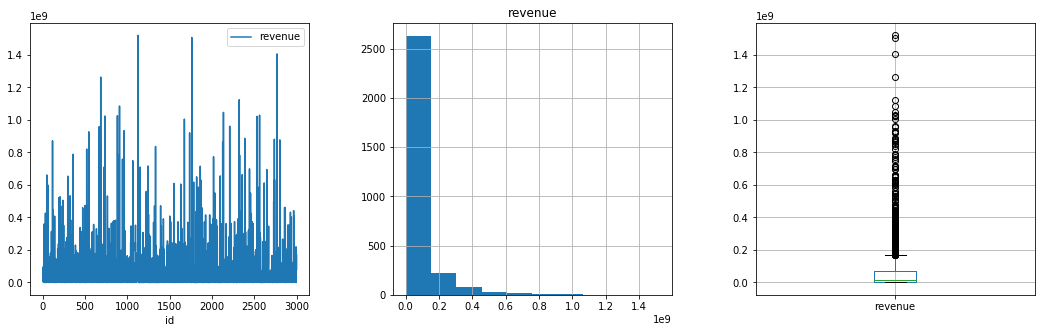

In [222]:
# check the distribution of target variable
fig, axes = plt.subplots(ncols=3,figsize=(18,5))

box_train[['revenue']].plot(ax=axes[0])
box_train[['revenue']].hist(ax=axes[1])
box_train[['revenue']].boxplot(ax=axes[2])

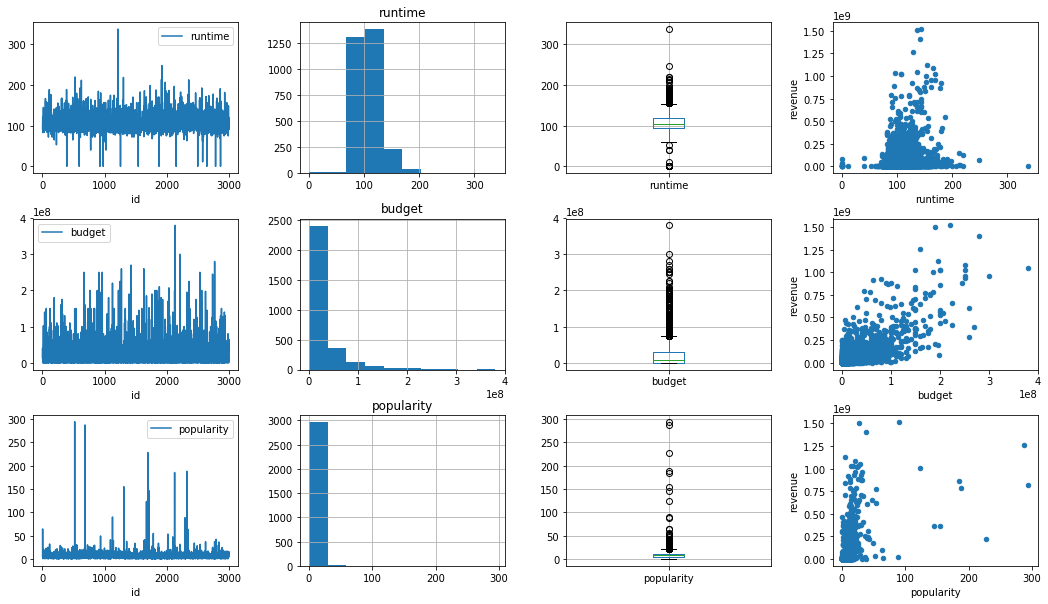

In [223]:
# check the numeric variables distribution and values in train set

fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(18,10))

box_train[['runtime']].plot(ax=axes[0,0])
box_train[['runtime']].hist(ax=axes[0,1])
box_train[['runtime']].boxplot(ax=axes[0,2])
box_train.plot.scatter(x='runtime', y='revenue', ax=axes[0,3])

box_train[['budget']].plot(ax=axes[1,0])
box_train[['budget']].hist(ax=axes[1,1])
box_train[['budget']].boxplot(ax=axes[1,2])
box_train.plot.scatter(x='budget', y='revenue', ax=axes[1,3])

box_train[['popularity']].plot(ax=axes[2,0])
box_train[['popularity']].hist(ax=axes[2,1])
box_train[['popularity']].boxplot(ax=axes[2,2])
box_train.plot.scatter(x='popularity', y='revenue', ax=axes[2,3])

For popularitym runtime and budget, most observations are within certain range. However there are some observations with big value. From the scatter plot of budget and revenue, we can see there may be some linear relationship between them.

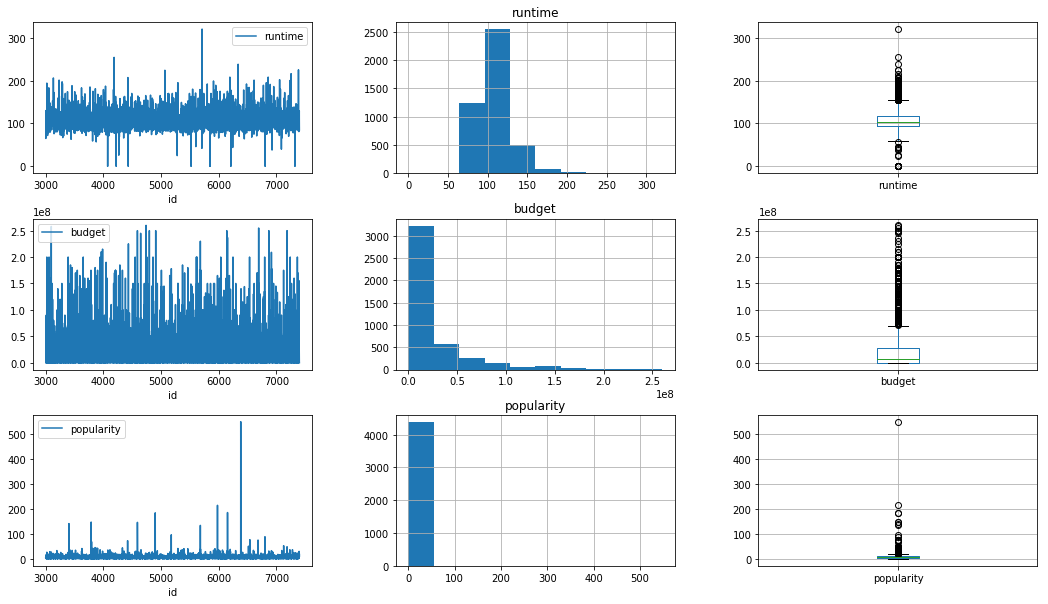

In [224]:
# check the numeric variables distribution and values in test set

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(18,10))

box_test[['runtime']].plot(ax=axes[0,0])
box_test[['runtime']].hist(ax=axes[0,1])
box_test[['runtime']].boxplot(ax=axes[0,2])

box_test[['budget']].plot(ax=axes[1,0])
box_test[['budget']].hist(ax=axes[1,1])
box_test[['budget']].boxplot(ax=axes[1,2])

box_test[['popularity']].plot(ax=axes[2,0])
box_test[['popularity']].hist(ax=axes[2,1])
box_test[['popularity']].boxplot(ax=axes[2,2])

Then we try to get a general idea of what words appear in the overview, title and tag line of train and test sets.

(-0.5, 1199.5, 999.5, -0.5)

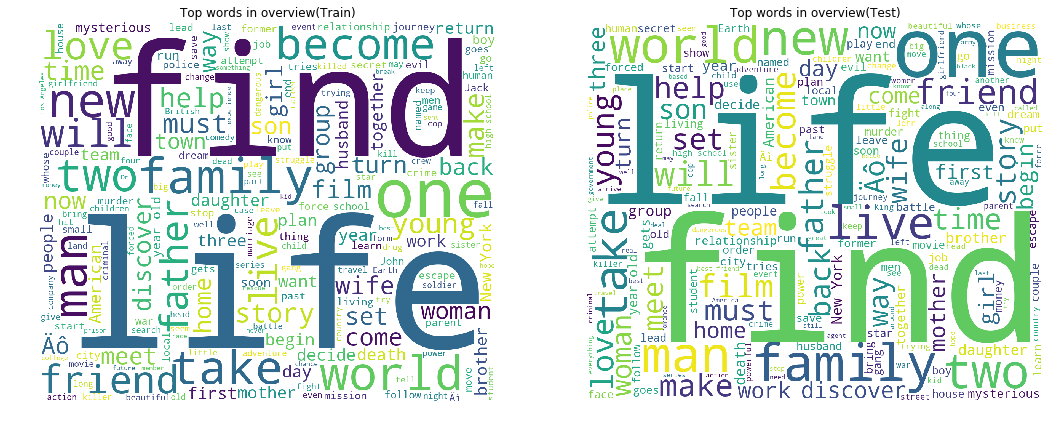

In [225]:
# get the world could of overview
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,18))


text = ' '.join(box_train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax1.imshow(wordcloud)
ax1.set_title('Top words in overview(Train)')
ax1.axis("off")


text = ' '.join(box_test['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax2.imshow(wordcloud)
ax2.set_title('Top words in overview(Test)')
ax2.axis("off")

(-0.5, 1199.5, 999.5, -0.5)

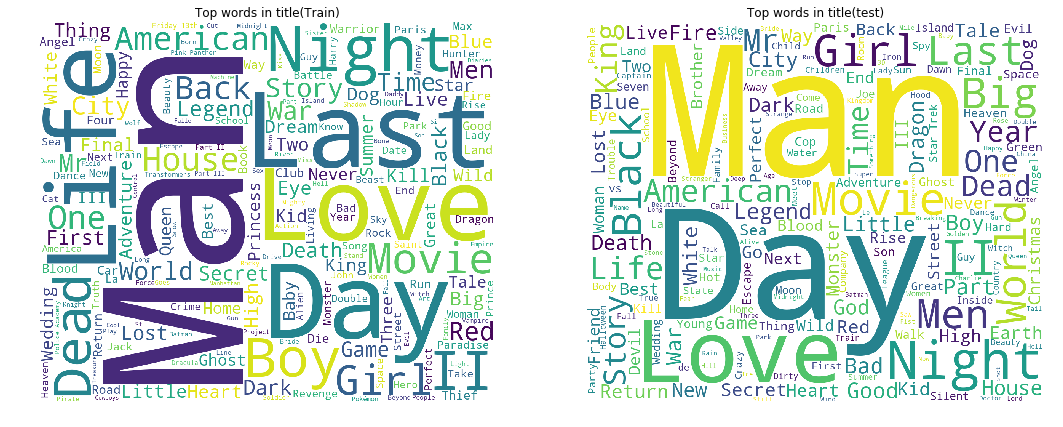

In [226]:
# get the world could of title
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,18))

text = ' '.join(box_train['title'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax1.imshow(wordcloud)
ax1.set_title('Top words in title(Train)')
ax1.axis("off")

text = ' '.join(box_test['title'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax2.imshow(wordcloud)
ax2.set_title('Top words in title(test)')
ax2.axis("off")

(-0.5, 1199.5, 999.5, -0.5)

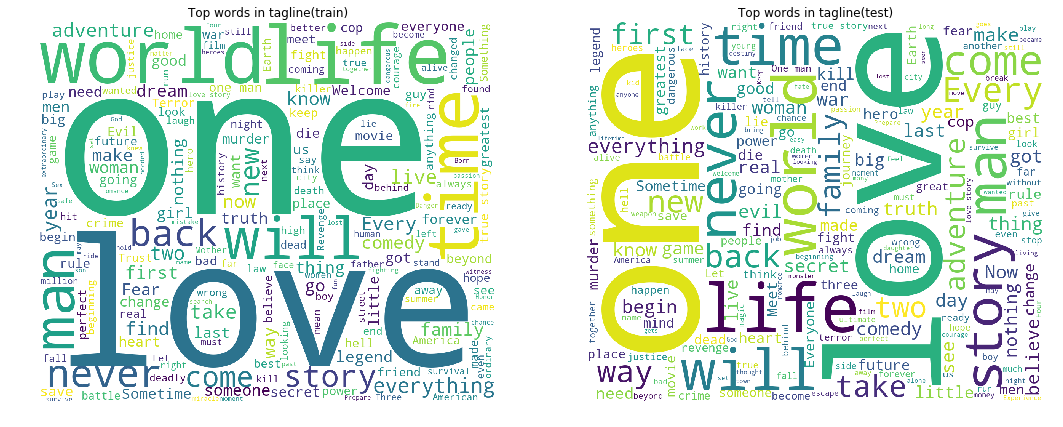

In [227]:
# get the world could of tagline
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,18))

text = ' '.join(box_train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax1.imshow(wordcloud)
ax1.set_title('Top words in tagline(train)')
ax1.axis("off")

text = ' '.join(box_test['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax2.imshow(wordcloud)
ax2.set_title('Top words in tagline(test)')
ax2.axis("off")

From above word cloud, we found that some words are more frequently used in movie's title, tagline and overview of both train and test set. In order to know whether those words have a predict power of the target variable, we will use the top used word to train the model.

---

### Part 3 Data Manipulating & Feature Engineering

In [395]:
train = box_train

In [396]:
test = box_test

---

#### belongs_to_collection

Drop the columns because too many missing values

In [397]:
train = train.drop(columns = 'belongs_to_collection')
test = test.drop(columns = 'belongs_to_collection')

---

#### budget
After check the value of this variable in both train and test set, we decide to keep this variable unchanged so far.

In [398]:
# budget - check numbers
train['budget'].sort_values()

id
896             0
595             0
596             0
1253            0
2145            0
2147            0
2578            0
1241            0
2149            0
1233            0
607             0
608             0
2154            0
610             0
1226            0
2161            0
1222            0
2163            0
1217            0
616             0
617             0
2572            0
1216            0
620             0
1254            0
1215            0
1255            0
591             0
565             0
566             0
          ...    
1674    185000000
903     185000000
1395    190000000
1762    190000000
2323    195000000
928     195000000
2624    197471676
882     200000000
764     200000000
2563    200000000
1839    200000000
2127    200000000
1223    200000000
1812    200000000
2036    207000000
1881    210000000
1127    220000000
1250    225000000
2358    225000000
2738    245000000
962     250000000
2533    250000000
667     250000000
907     250000000
1271   

In [399]:
test['budget'].sort_values()

id
3001            0
5283            0
5284            0
5286            0
5287            0
3834            0
5288            0
5294            0
5300            0
3829            0
5303            0
5315            0
5317            0
3825            0
5318            0
5322            0
3839            0
5331            0
5280            0
5275            0
3858            0
5252            0
3856            0
3855            0
3854            0
5254            0
5257            0
5258            0
5260            0
5265            0
          ...    
4860    200000000
5612    200000000
4551    200000000
6035    200000000
3389    200000000
6796    200000000
3020    200000000
7239    200000000
6247    200000000
5624    200000000
6534    200000000
7363    200000000
4754    200000000
3651    200000000
6913    209000000
3964    210000000
3986    215000000
4434    225000000
5681    230000000
6152    237000000
4646    245000000
7184    250000000
6868    250000000
4907    250000000
4797   

---

#### homepage
One hot encoding

"1" for the observations that have homepages. 

"0" for the observations that don't have homepages.

In [400]:
train['has_homepage'] = 1
train.loc[pd.isnull(train['homepage']) ,"has_homepage"] = 0
# test
test['has_homepage'] = 1
test.loc[pd.isnull(test['homepage']) ,"has_homepage"] = 0

In [401]:
train = train.drop(columns = 'homepage')
test = test.drop(columns = 'homepage')
test.head(2)

,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,has_homepage
id,,,,,,,,,,,,,,,,,,,,
3001,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'},...",tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newcomer Dawn) arrive at...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket ...","[{'cast_id': 3, 'character': 'Tonio', 'credit_id': '52fe44e7c3a368...","[{'credit_id': '52fe44e7c3a368484e03d683', 'department': 'Directin...",1
3002,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fictio...",tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size because of an alien encoun...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'id': 9233}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951, 'name': 'alien'}, {...","[{'cast_id': 2, 'character': 'Nancy Fowler Archer', 'credit_id': '...","[{'credit_id': '55807805c3a3685b1300060b', 'department': 'Editing'...",0


---

#### imdb_id

Drop the column because it is not useful for prediction.

In [402]:
train = train.drop(columns = 'imdb_id')
test = test.drop(columns = 'imdb_id')


test.head(2)

,budget,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,has_homepage
id,,,,,,,,,,,,,,,,,,,
3001,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'},...",ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newcomer Dawn) arrive at...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket ...","[{'cast_id': 3, 'character': 'Tonio', 'credit_id': '52fe44e7c3a368...","[{'credit_id': '52fe44e7c3a368484e03d683', 'department': 'Directin...",1
3002,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fictio...",en,Attack of the 50 Foot Woman,When an abused wife grows to giant size because of an alien encoun...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'id': 9233}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951, 'name': 'alien'}, {...","[{'cast_id': 2, 'character': 'Nancy Fowler Archer', 'credit_id': '...","[{'credit_id': '55807805c3a3685b1300060b', 'department': 'Editing'...",0


---

#### genres

one hot encoding for each of the movie classification



In [403]:
#get genres dummies for train
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d
train = train
train['genres'] = train['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres_tr = train.genres.str.get_dummies(sep=',')
train = pd.concat([train, genres_tr], axis=1, sort=False)

In [404]:
train.head(2)

,budget,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,Comedy,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the Internet,"" is shot by ...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,...,0,0,0,0,0,0,0,0,0,0
2,40000000,"Comedy,Drama,Family,Romance",en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and on her way to Genovi...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,...,0,0,0,0,1,0,0,0,0,0


In [405]:
#get genres dummies for test
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d
test = test
test['genres'] = test['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres_te = test.genres.str.get_dummies(sep=',')
test = pd.concat([test, genres_te], axis=1, sort=False)

In [406]:
test.head(2)

,budget,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
3001,0,"Adventure,Animation,Family,Fantasy",ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newcomer Dawn) arrive at...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name...",7/14/07,...,0,0,0,0,0,0,0,0,0,0
3002,88000,"Horror,Science Fiction",en,Attack of the 50 Foot Woman,When an abused wife grows to giant size because of an alien encoun...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'id': 9233}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/19/58,...,0,0,1,0,0,0,1,0,0,0


In [407]:
# after doing one hot encocoding we found there is one more genres in the train set than in the test set
# we still keep this column in the train set
set([i for i in genres_tr.columns]) - set([i for i in genres_te.columns])

{'TV Movie'}

In [408]:
train['TV Movie'].sum()
# there is only one observation with this genres, we decided to drop this column

1

In [409]:
train = train.drop(columns = ['genres','TV Movie'])
test = test.drop(columns = 'genres')
train.head(2)

,budget,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the Internet,"" is shot by ...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,...,0,0,0,0,0,0,0,0,0,0
2,40000000,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and on her way to Genovi...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,...,0,0,0,0,0,1,0,0,0,0


---

#### original_title

Drop the column because there are too many languages here also can use title column for prediction.

In [410]:
train = train.drop(columns = 'original_title')
test = test.drop(columns = 'original_title')

train.head(2)

,budget,original_language,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,"When Lou, who has become the ""father of the Internet,"" is shot by ...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0,0,0,0,0,0,0,0,0,0
2,40000000,en,Mia Thermopolis is now a college graduate and on her way to Genovi...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,0,0,0,0,0,1,0,0,0,0


---

#### overview
1. Count the number of the words in overview

2. One hot encoding for the most appeared words

In [411]:
train['overview']=train['overview'].fillna('')
test['overview']=test['overview'].fillna('')

In [412]:
# first we will count the number of word in each overview
count_list = []
for line in train.overview:
    if line != '':
        count = len(re.findall(r'\w+', str(line)))
    else:
        count = 0
    count_list.append(count)
train['overview_count'] = count_list

In [413]:
# Overview - first we will count the number of word in each overview
count_list_tst = []
for line in test.overview:
    if line != '':
        count = len(re.findall(r'\w+', str(line)))
    else:
        count = 0
    count_list_tst.append(count)
test['overview_count'] = count_list_tst

In [414]:
nltk.download('stopwords')## download least word list

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/renluzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [415]:
# get the word frequency dictionary from train set
d = {}
for line in train.overview:
    a = re.findall(r'\w+', str(line).lower())
    ps = PorterStemmer()
    no_sws = [ps.stem(word) for word in a if not word in set(stopwords.words('english'))]
    for n in no_sws:
        keys = d.keys()
        if n in keys:
            d[n] += 1
        else:
            d[n] = 1
wdict_rv = dict([(i,d[i]) for i in sorted(d, key=d.get, reverse=True)])

In [416]:
wdict_rv

{'life': 607,
 'find': 506,
 'one': 423,
 'new': 417,
 'love': 410,
 'young': 394,
 'year': 378,
 'man': 365,
 'take': 360,
 'world': 359,
 'get': 358,
 'stori': 338,
 'live': 337,
 'two': 335,
 'famili': 329,
 'friend': 320,
 'becom': 312,
 'must': 260,
 'make': 255,
 'help': 248,
 'film': 245,
 'father': 243,
 'time': 241,
 'tri': 238,
 'turn': 228,
 'come': 219,
 'war': 212,
 'way': 209,
 'set': 209,
 'old': 208,
 'woman': 206,
 'discov': 203,
 'day': 200,
 'meet': 199,
 'forc': 198,
 'wife': 195,
 'work': 195,
 'town': 191,
 'murder': 191,
 'son': 181,
 'girl': 180,
 'kill': 179,
 'school': 178,
 'back': 176,
 'home': 172,
 'begin': 170,
 'fall': 170,
 'citi': 160,
 'äô': 160,
 'go': 157,
 'group': 155,
 'death': 154,
 'name': 151,
 'soon': 150,
 'mysteri': 150,
 'american': 149,
 'follow': 149,
 'plan': 149,
 'want': 147,
 'decid': 146,
 'daughter': 146,
 'first': 144,
 'brother': 144,
 'mother': 142,
 'three': 142,
 'face': 141,
 'boy': 140,
 'team': 139,
 'return': 139,
 'secret

In [417]:
# get the top 5 word used in overview
topov_list = [k for k in list(wdict_rv)[:5]]
topov_list

['life', 'find', 'one', 'new', 'love']

In [418]:
overview_df = pd.DataFrame(0,columns = ['overview_'+str(topov_list[0]),'overview_'+str(topov_list[1]),\
                                      'overview_'+str(topov_list[2]),'overview_'+str(topov_list[3]),\
                                       'overview_'+str(topov_list[4])],\
                                        index = [i for i in range(train.index[0],train.index[-1]+1)])

In [419]:
# one hot encoding of overview for train 
for line in train.overview:
    word = re.findall(r'\w+', str(line).lower())
    ps = PorterStemmer()
    for w in word:
        a=ps.stem(w)
        if a in topov_list:
            overview_df.at[train[train['overview'] == line].index,'overview_'+str(a)] = 1 
train = pd.concat([train, overview_df], axis=1, sort=False)

In [420]:
overview_df2 = pd.DataFrame(0,columns = ['overview_'+str(topov_list[0]),'overview_'+str(topov_list[1]),\
                                      'overview_'+str(topov_list[2]),'overview_'+str(topov_list[3]),\
                                       'overview_'+str(topov_list[4])],\
                                        index = [i for i in range(test.index[0],test.index[-1]+1)])

In [421]:
# one hot encoding of overview for test 
for line in test.overview:
    word = re.findall(r'\w+', str(line).lower())
    ps = PorterStemmer()
    for w in word:
        a=ps.stem(w)
        if w in topov_list:
            overview_df2.at[test[test['overview'] == line].index,'overview_'+str(a)] = 1 
test = pd.concat([test, overview_df2], axis=1, sort=False)

In [422]:
train = train.drop(columns = 'overview')
test = test.drop(columns = 'overview')
train.head(2)

,budget,original_language,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,...,Science Fiction,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,0,0,0,0,29,0,0,0,0,0
2,40000000,en,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,0,0,0,0,70,1,0,0,0,0


---

#### popularity

After checking the value, we decide to keep the column unchannged so far.

In [424]:
train['popularity'].sort_values().head()
#keep

id
2557    0.000001
1684    0.000308
742     0.000578
1504    0.000844
774     0.001272
Name: popularity, dtype: float64

In [425]:
# check the correlation between budget and revenue
train['budget'].corr(train['revenue'])

0.7529645103815287

In [426]:
test['popularity'].sort_values().head()

id
3831    0.000001
3244    0.000464
6450    0.000657
7341    0.001223
4222    0.001393
Name: popularity, dtype: float64

---

#### poster_path

Since this column is the links for movie poster, we decide to drop the column.

In [427]:
train = train.drop(columns = 'poster_path')
test = test.drop(columns = 'poster_path')
train.head(2)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,...,Science Fiction,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,...,0,0,0,0,29,0,0,0,0,0
2,40000000,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,...,0,0,0,0,70,1,0,0,0,0


In [428]:
test.head(2)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,...,Science Fiction,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,...,0,0,0,0,57,0,0,0,0,0
3002,88000,en,3.559789,"[{'name': 'Woolner Brothers Pictures Inc.', 'id': 9233}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,...,1,0,0,0,29,0,0,0,0,0


---

#### production_companies 

1. count the number of the production companies
2. list the three most appeared companies and one hot encoding

In [429]:
company_df = train['production_companies'].str.split(',', expand = True) 
company_df_drop = company_df.drop(columns=[i for i in list(company_df.columns) if i%2 == 1])
company_df_drop_s = pd.DataFrame()

for col in company_df_drop.columns:
    company_df_drop_s[col] = company_df_drop[col].str.split("'").str[3]
company_df_drop_s = company_df_drop_s.fillna('None')

cop_list = []
for i in company_df_drop_s.index:
    cop_num = 0
    for c in company_df_drop_s.columns:
        if company_df_drop_s.at[i,c] != 'None':
            cop_num = cop_num + 1
    cop_list.append(cop_num)
train['company_count'] = cop_list

In [430]:
train.head(2)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,...,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love,company_count
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,...,0,0,0,29,0,0,0,0,0,3
2,40000000,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,...,0,0,0,70,1,0,0,0,0,1


In [431]:
# test
company_df_tst = test['production_companies'].str.split(',', expand = True) 
company_df_drop_tst = company_df_tst.drop(columns=[i for i in list(company_df_tst.columns) if i%2 == 1])
company_df_drop_s_tst = pd.DataFrame()

for col in company_df_drop_tst.columns:
    company_df_drop_s_tst[col] = company_df_drop_tst[col].str.split("'").str[3]
company_df_drop_s_tst = company_df_drop_s_tst.fillna('None')

cop_list_tst = []
for i in company_df_drop_s_tst.index:
    cop_num = 0
    for c in company_df_drop_s_tst.columns:
        if company_df_drop_s_tst.at[i,c] != 'None':
            cop_num = cop_num + 1
    cop_list_tst.append(cop_num)
test['company_count'] = cop_list_tst

In [432]:
test.head(2)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,...,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love,company_count
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,...,0,0,0,57,0,0,0,0,0,0
3002,88000,en,3.559789,"[{'name': 'Woolner Brothers Pictures Inc.', 'id': 9233}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,...,0,0,0,29,0,0,0,0,0,1


In [433]:
# also we list most appeared company dictionary from train set
d = {}
for col in company_df_drop_s.columns:
    for n in company_df_drop_s[col]:
        keys = d.keys()
        if n in keys:
            d[n] += 1
        else:
            d[n] = 1
company_dict = dict([(i,d[i]) for i in sorted(d, key=d.get, reverse=True)])

In [434]:
company_dict

{'None': 42933,
 'Warner Bros.': 201,
 'Universal Pictures': 188,
 'Paramount Pictures': 161,
 'Twentieth Century Fox Film Corporation': 138,
 'Columbia Pictures': 91,
 'Metro-Goldwyn-Mayer (MGM)': 84,
 'New Line Cinema': 75,
 'Walt Disney Pictures': 62,
 'Touchstone Pictures': 62,
 'Columbia Pictures Corporation': 61,
 'TriStar Pictures': 53,
 'Relativity Media': 48,
 'Canal+': 46,
 'United Artists': 44,
 'Miramax Films': 40,
 'Village Roadshow Pictures': 36,
 'Regency Enterprises': 31,
 'BBC Films': 30,
 'Working Title Films': 30,
 'Dune Entertainment': 30,
 'Fox Searchlight Pictures': 29,
 'Lionsgate': 28,
 'StudioCanal': 28,
 'DreamWorks SKG': 27,
 'Fox 2000 Pictures': 25,
 'Summit Entertainment': 24,
 'Hollywood Pictures': 24,
 'Orion Pictures': 24,
 'Dimension Films': 23,
 'Amblin Entertainment': 23,
 'Castle Rock Entertainment': 21,
 'Epsilon Motion Pictures': 21,
 'Original Film': 21,
 'Morgan Creek Productions': 21,
 'Focus Features': 21,
 'Legendary Pictures': 19,
 'Participa

In [435]:
# use top four company to do the one hot encoding
production_company_list = [k for k in list(company_dict)[1:5]]
production_company_list

['Warner Bros.',
 'Universal Pictures',
 'Paramount Pictures',
 'Twentieth Century Fox Film Corporation']

In [436]:
production_company_df = pd.DataFrame(0,columns = ['production_company_'+str(production_company_list[0]),'production_company_'+str(production_company_list[1]),\
                                      'production_company_'+str(production_company_list[2]),'production_company_'+str(production_company_list[3])],\
                                      index = [i for i in range(train.index[0],train.index[-1]+1)])

In [437]:
# get company one hot encoding for train
for col in company_df_drop_s.columns:
    for company in company_df_drop_s[col]:
        if company in production_company_list:
            production_company_df.at[company_df_drop_s[company_df_drop_s[col] == company].index,'production_company_'+str(company)] = 1

In [438]:
train = pd.concat([train, production_company_df], axis=1, sort=False)
train.head(2)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,...,overview_life,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,...,0,0,0,0,0,3,0,0,1,0
2,40000000,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,...,1,0,0,0,0,1,0,0,0,0


In [439]:
production_company_df_tst = pd.DataFrame(0,columns = ['production_company_'+str(production_company_list[0]),'production_company_'+str(production_company_list[1]),\
                                      'production_company_'+str(production_company_list[2]),'production_company_'+str(production_company_list[3])],\
                                      index = [i for i in range(test.index[0],test.index[-1]+1)])

In [440]:
# get company one hot encoding for test
for col in company_df_drop_s_tst.columns:
    for company in company_df_drop_s_tst[col]:
        if company in production_company_list:
            production_company_df_tst.at[company_df_drop_s_tst[company_df_drop_s_tst[col] == company].index,'production_company_'+str(company)] = 1
            

In [441]:
test = pd.concat([test, production_company_df_tst], axis=1, sort=False)
test.head(2)

,budget,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,...,overview_life,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_3166_1': 'US', 'name...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,...,0,0,0,0,0,0,0,0,0,0
3002,88000,en,3.559789,"[{'name': 'Woolner Brothers Pictures Inc.', 'id': 9233}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,...,0,0,0,0,0,1,0,0,0,0


In [442]:
train = train.drop(columns = 'production_companies')
test = test.drop(columns = 'production_companies')

In [443]:
train.head(2)

,budget,original_language,popularity,production_countries,release_date,runtime,spoken_languages,status,tagline,title,...,overview_life,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,Hot Tub Time Machine 2,...,0,0,0,0,0,3,0,0,1,0
2,40000000,en,8.248895,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,The Princess Diaries 2: Royal Engagement,...,1,0,0,0,0,1,0,0,0,0


---

#### production_countries 

Count the number of production countries

In [444]:
country_df = train['production_countries'].str.split(',', expand = True)
countries_df_drop = country_df.drop(columns=[i for i in list(country_df.columns) if i%2 == 1])
countries_df_drop_s = pd.DataFrame()

for col in countries_df_drop.columns:
    countries_df_drop_s[col] = countries_df_drop[col].str.split("'").str[3]
    
countries_df_drop_s = countries_df_drop_s.fillna('None')

In [445]:
countries_df_drop_s.head()

,0,2,4,6,8,10,12,14
id,,,,,,,,
1,US,None,None,None,None,None,None,None
2,US,None,None,None,None,None,None,None
3,US,None,None,None,None,None,None,None
4,IN,None,None,None,None,None,None,None
5,KR,None,None,None,None,None,None,None


In [446]:
# count the number of countries of production for train
country_list = []
for i in countries_df_drop_s.index:
    country_num = 0
    for c in countries_df_drop_s.columns:
        if countries_df_drop_s.at[i,c] != 'None':
            country_num = country_num + 1
    country_list.append(country_num)
country_list

[1,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 5,
 1,
 5,
 1,
 1,
 3,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 2,
 8,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 2,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 4,
 1,
 2,
 1,
 1,
 4,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,


In [447]:
train['production_country_count'] = country_list

In [448]:
country_df_tst = test['production_countries'].str.split(',', expand = True) 
countries_df_drop_tst = country_df_tst.drop(columns=[i for i in list(country_df_tst.columns) if i%2 == 1])
countries_df_drop_s_tst = pd.DataFrame()
for col in countries_df_drop_tst.columns:
    countries_df_drop_s_tst[col] = countries_df_drop_tst[col].str.split("'").str[3]
countries_df_drop_s_tst = countries_df_drop_s_tst.fillna('None')
countries_df_drop_s_tst.head()

,0,2,4,6,8,10,12,14,16,18,20,22
id,,,,,,,,,,,,
3001,JP,US,None,None,None,None,None,None,None,None,None,None
3002,US,None,None,None,None,None,None,None,None,None,None,None
3003,US,None,None,None,None,None,None,None,None,None,None,None
3004,CA,FR,None,None,None,None,None,None,None,None,None,None
3005,US,None,None,None,None,None,None,None,None,None,None,None


In [449]:
# count the number of countries of production for test
country_list_tst = []
for i in countries_df_drop_s_tst.index:
    country_num = 0
    for c in countries_df_drop_s_tst.columns:
        if countries_df_drop_s_tst.at[i,c] != 'None':
            country_num = country_num + 1
    country_list_tst.append(country_num)
country_list_tst

[2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 3,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 4,
 1,
 1,
 6,
 2,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 3,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,


In [450]:
test['production_country_count'] = country_list_tst

In [451]:
train = train.drop(columns = 'production_countries')
test = test.drop(columns = 'production_countries')

In [452]:
train.head(2)

,budget,original_language,popularity,release_date,runtime,spoken_languages,status,tagline,title,Keywords,...,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel...",...,0,0,0,0,3,0,0,1,0,1
2,40000000,en,8.248895,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'},...",...,0,0,0,0,1,0,0,0,0,1


---

#### Date

Use the original variable to separate the month, day, year and generate dayof week

In [453]:
# train
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
train['release_year'] = train['release_year']
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900
train['release_date'] = pd.to_datetime(train['release_date'], format="%m/%d/%y")
train['dayofweek'] = train['release_date'].dt.dayofweek

In [454]:
# test
test[['release_month','release_day','release_year']]=test['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
test['release_year'] = test['release_year']
test.loc[ (test['release_year'] <= 19) & (test['release_year'] < 100), "release_year"] += 2000
test.loc[ (test['release_year'] > 19)  & (test['release_year'] < 100), "release_year"] += 1900
test['release_date'] = pd.to_datetime(test['release_date'], format="%m/%d/%y")
test['dayofweek'] = test['release_date'].dt.dayofweek

In [455]:
test.head(2)

,budget,original_language,popularity,release_date,runtime,spoken_languages,status,tagline,title,Keywords,...,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,2007-07-14,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket ...",...,0,0,0,0,0,2,7,14,2007,5.0
3002,88000,en,3.559789,2058-05-19,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951, 'name': 'alien'}, {...",...,1,0,0,0,0,1,5,19,1958,6.0


In [456]:
train = train.drop(columns = 'release_date')
test = test.drop(columns = 'release_date')
test.head(2)

,budget,original_language,popularity,runtime,spoken_languages,status,tagline,title,Keywords,cast,...,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket ...","[{'cast_id': 3, 'character': 'Tonio', 'credit_id': '52fe44e7c3a368...",...,0,0,0,0,0,2,7,14,2007,5.0
3002,88000,en,3.559789,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951, 'name': 'alien'}, {...","[{'cast_id': 2, 'character': 'Nancy Fowler Archer', 'credit_id': '...",...,1,0,0,0,0,1,5,19,1958,6.0


----

#### runtime

Fill NaN cell with 0

In [457]:
train['runtime'] = train['runtime'].fillna(0)
test['runtime'] = test['runtime'].fillna(0)

---

#### spoken_languages

Count how many languages are spoken in each movie

In [458]:
lan_df = train['spoken_languages'].str.split(',', expand = True)
lan_df_drop = lan_df.drop(columns=[i for i in list(lan_df.columns) if i%2 == 1])
lan_df_drop_s = pd.DataFrame()
for col in lan_df_drop.columns:
    lan_df_drop_s[col] = lan_df_drop[col].str.split("'").str[3]
lan_df_drop_s = lan_df_drop_s.fillna('None')

In [459]:
# get the count of spoken language from train
lan_list = []
for i in lan_df_drop_s.index:
    lan_num = 0
    for c in lan_df_drop_s.columns:
        if lan_df_drop_s.at[i,c] != 'None':
            lan_num = lan_num + 1
    lan_list.append(lan_num)
lan_list

[1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 7,
 5,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 3,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 2,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 6,
 1,
 1,
 1,
 4,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 2,
 4,


In [460]:
train['spoken_language_count'] = lan_list

In [461]:
# get the count of spoken language from test
lan_df_tst = test['spoken_languages'].str.split(',', expand = True) 

lan_df_drop_tst = lan_df_tst.drop(columns=[i for i in list(lan_df_tst.columns) if i%2 == 1])

lan_df_drop_s_tst = pd.DataFrame()
for col in lan_df_drop_tst.columns:
    lan_df_drop_s_tst[col] = lan_df_drop_tst[col].str.split("'").str[3]

lan_df_drop_s_tst = lan_df_drop_s_tst.fillna('None')

lan_list_tst = []
for i in lan_df_drop_s_tst.index:
    lan_num = 0
    for c in lan_df_drop_s_tst.columns:
        if lan_df_drop_s_tst.at[i,c] != 'None':
            lan_num = lan_num + 1
    lan_list_tst.append(lan_num)
lan_list_tst

[2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 4,
 1,
 2,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 2,
 1,
 2,
 3,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 4,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 4,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 3,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 5,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [462]:
test['spoken_language_count'] = lan_list_tst
test.head(2)

,budget,original_language,popularity,runtime,spoken_languages,status,tagline,title,Keywords,cast,...,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek,spoken_language_count
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ja', 'name...",Released,Somewhere Between Time & Space... A Legend Is Born.,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket ...","[{'cast_id': 3, 'character': 'Tonio', 'credit_id': '52fe44e7c3a368...",...,0,0,0,0,2,7,14,2007,5.0,2
3002,88000,en,3.559789,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of horror! A terrifying ma...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951, 'name': 'alien'}, {...","[{'cast_id': 2, 'character': 'Nancy Fowler Archer', 'credit_id': '...",...,0,0,0,0,1,5,19,1958,6.0,1


In [463]:
train = train.drop(columns = 'spoken_languages')
test = test.drop(columns = 'spoken_languages')

---

#### status

Change the string to boolean - released = 1, rumored = 0

In [464]:
train['has_Released'] = 1
train.loc[ train['status'] != "Released" ,"has_Released"] = 0
test['has_Released'] = 1
test.loc[ test['status'] != "Released" ,"has_Released"] = 0

In [465]:
train = train.drop(columns = 'status')
test = test.drop(columns = 'status')
train.head(2)

,budget,original_language,popularity,runtime,tagline,title,Keywords,cast,crew,revenue,...,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek,spoken_language_count,has_Released
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,The Laws of Space and Time are About to be Violated.,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel...","[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directin...",12314651,...,0,1,0,1,2,20,2015,4,1,1
2,40000000,en,8.248895,113.0,It can take a lifetime to find true love; she's got 30 days!,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'},...","[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directin...",95149435,...,0,0,0,1,8,6,2004,4,1,1


---

#### tagline

1. Count the number of words in the tagline
2. One hot encoding for the most appearing words in the tagline

In [466]:
train['tagline']=train['tagline'].fillna('')
test['tagline']=test['tagline'].fillna('')

# first we will count the number of word in each tagline
count_list = []
for line in train.tagline:
    if line != '':
        count = len(re.findall(r'\w+', str(line)))
    else:
        count = 0
    count_list.append(count)
train['tagline_count'] = count_list

count_list_tst = []
for line in test.tagline:
    if line != '':
        count = len(re.findall(r'\w+', str(line)))
    else:
        count = 0
    count_list_tst.append(count)
test['tagline_count'] = count_list_tst

In [467]:
# get the word count dictionary from tagline of train set
d = {}
for line in train.tagline:
    a = re.findall(r'\w+', str(line).lower())
    ps = PorterStemmer()
    no_sws = [ps.stem(word) for word in a if not word in set(stopwords.words('english'))]
    for n in no_sws:
        keys = d.keys()
        if n in keys:
            d[n] += 1
        else:
            d[n] = 1
tagdict_rv = dict([(i,d[i]) for i in sorted(d, key=d.get, reverse=True)])

In [468]:
tagdict_rv

{'one': 213,
 'love': 152,
 'world': 108,
 'life': 104,
 'stori': 104,
 'man': 104,
 'time': 97,
 'never': 91,
 'get': 83,
 'back': 72,
 'come': 72,
 'go': 65,
 'live': 61,
 'new': 55,
 'everyth': 51,
 'adventur': 50,
 'find': 49,
 'take': 48,
 'true': 48,
 'year': 45,
 'chang': 45,
 'dream': 45,
 'know': 45,
 'comedi': 45,
 'two': 44,
 'make': 43,
 'everi': 41,
 'want': 41,
 'famili': 40,
 'first': 39,
 'begin': 38,
 'need': 38,
 'like': 38,
 'way': 38,
 'fear': 37,
 'ever': 37,
 'noth': 37,
 'look': 36,
 'woman': 35,
 'thing': 34,
 'save': 34,
 'someon': 33,
 'fight': 33,
 'truth': 32,
 'peopl': 32,
 'legend': 32,
 'die': 32,
 'murder': 32,
 'girl': 31,
 'last': 31,
 'men': 31,
 'day': 30,
 'greatest': 30,
 'good': 30,
 'got': 29,
 'sometim': 29,
 'friend': 29,
 'beyond': 29,
 'power': 28,
 'would': 28,
 'happen': 27,
 'littl': 27,
 'secret': 27,
 'heart': 27,
 'best': 26,
 'welcom': 26,
 'surviv': 26,
 'hero': 26,
 'us': 26,
 'everyon': 25,
 'big': 25,
 'forev': 25,
 'evil': 24,
 'r

In [469]:
# get the top 6 word used in overview
toptag_list = [k for k in list(tagdict_rv)[0:6]]
toptag_list

['one', 'love', 'world', 'life', 'stori', 'man']

In [470]:
tagline_df = pd.DataFrame(0,columns = ['tagline_'+str(toptag_list[0]),'tagline_'+str(toptag_list[1]),\
                                      'tagline_'+str(toptag_list[2]),'tagline_'+str(toptag_list[3]),\
                                       'tagline_'+str(toptag_list[4]),'tagline_'+str(toptag_list[5])],\
                          index = [i for i in range(train.index[0],train.index[-1]+1)])
# one hot encoding for train
for line in train.tagline:
    word = re.findall(r'\w+', str(line).lower())
    ps = PorterStemmer()
    for w in word:
        a = ps.stem(w)
        if a in toptag_list:
            tagline_df.at[train[train['tagline'] == line].index,'tagline_'+str(a)] = 1 

In [471]:
train = pd.concat([train, tagline_df], axis=1, sort=False)

In [472]:
tagline_df_tst = pd.DataFrame(0,columns = ['tagline_'+str(toptag_list[0]),'tagline_'+str(toptag_list[1]),\
                                      'tagline_'+str(toptag_list[2]),'tagline_'+str(toptag_list[3]),\
                                       'tagline_'+str(toptag_list[4]),'tagline_'+str(toptag_list[5])],\
                          index = [i for i in range(test.index[0],test.index[-1]+1)])

# one hot encoding for test
for line in test.tagline:
    word = re.findall(r'\w+', str(line).lower())
    ps = PorterStemmer()
    for w in word:
        a = ps.stem(w)
        if a in toptag_list:
            tagline_df_tst.at[test[test['tagline'] == line].index,'tagline_'+str(a)] = 1 

In [473]:
test = pd.concat([test, tagline_df_tst], axis=1, sort=False)

In [474]:
train = train.drop(columns = 'tagline')
test = test.drop(columns = 'tagline')

train.head(2)

,budget,original_language,popularity,runtime,title,Keywords,cast,crew,revenue,has_homepage,...,dayofweek,spoken_language_count,has_Released,tagline_count,tagline_one,tagline_love,tagline_world,tagline_life,tagline_stori,tagline_man
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel...","[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directin...",12314651,0,...,4,1,1,11,0,0,0,0,0,0
2,40000000,en,8.248895,113.0,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'},...","[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directin...",95149435,0,...,4,1,1,14,0,1,0,0,0,0


---

#### title

Count the number of words in the title

In [475]:
train['title']=train['title'].fillna('')
test['title']=test['title'].fillna('')

In [476]:
#count the number of words in the title
count_list = []
for line in train.title:
    if line != '':
        count = len(re.findall(r'\w+', str(line)))
    else:
        count = 0
    count_list.append(count)
train['title_count'] = count_list


count_list_tst = []
for line in test.title:
    if line != '':
        count = len(re.findall(r'\w+', str(line)))
    else:
        count = 0
    count_list_tst.append(count)
test['title_count'] = count_list_tst
test.head(2)

,budget,original_language,popularity,runtime,title,Keywords,cast,crew,has_homepage,Action,...,spoken_language_count,has_Released,tagline_count,tagline_one,tagline_love,tagline_world,tagline_life,tagline_stori,tagline_man,title_count
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,90.0,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 11551, 'name': 'pocket ...","[{'cast_id': 3, 'character': 'Tonio', 'credit_id': '52fe44e7c3a368...","[{'credit_id': '52fe44e7c3a368484e03d683', 'department': 'Directin...",1,0,...,2,1,8,0,0,0,0,0,0,5
3002,88000,en,3.559789,65.0,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951, 'name': 'alien'}, {...","[{'cast_id': 2, 'character': 'Nancy Fowler Archer', 'credit_id': '...","[{'credit_id': '55807805c3a3685b1300060b', 'department': 'Editing'...",0,0,...,1,1,16,0,0,0,0,0,0,6


In [477]:
# check the word count for title
d = {}
for line in train.title:
    a = re.findall(r'\w+', str(line).lower())
    ps = PorterStemmer()
    no_sws = [ps.stem(word) for word in a if not word in set(stopwords.words('english'))]
    for n in no_sws:
        keys = d.keys()
        if n in keys:
            d[n] += 1
        else:
            d[n] = 1
titledict_rv = dict([(i,d[i]) for i in sorted(d, key=d.get, reverse=True)])

In [478]:
titledict_rv
## since the world count is very small, we decide not to use the one hot encoding for title 

{'2': 70,
 'man': 37,
 'love': 34,
 'last': 33,
 'day': 33,
 'ii': 29,
 'life': 29,
 'night': 25,
 'boy': 23,
 'movi': 23,
 '3': 22,
 'dead': 21,
 'girl': 19,
 'part': 19,
 'time': 18,
 'american': 18,
 'hous': 18,
 'one': 18,
 'live': 18,
 'back': 17,
 'stori': 17,
 'red': 16,
 'dark': 16,
 'war': 16,
 'world': 15,
 'kill': 15,
 'mr': 15,
 'men': 15,
 'citi': 15,
 'legend': 15,
 'big': 15,
 'iii': 14,
 'black': 14,
 'death': 14,
 'game': 14,
 'lost': 13,
 'star': 13,
 'secret': 13,
 'first': 13,
 'kid': 13,
 'eye': 12,
 'thing': 12,
 'happi': 12,
 'high': 12,
 'final': 11,
 'wed': 11,
 'dream': 11,
 'blue': 11,
 'littl': 11,
 'heart': 11,
 'new': 11,
 'adventur': 11,
 'two': 11,
 'dog': 11,
 'summer': 10,
 'run': 10,
 'miss': 10,
 'king': 10,
 'white': 10,
 'like': 10,
 'street': 10,
 'princess': 9,
 'beauti': 9,
 'hour': 9,
 'queen': 9,
 'babi': 9,
 'angel': 9,
 'wild': 9,
 'guy': 9,
 'die': 9,
 'never': 9,
 'ghost': 9,
 'home': 9,
 'fire': 9,
 'tale': 9,
 'evil': 9,
 'three': 9,
 'd

In [479]:
train = train.drop(columns = 'title')
test = test.drop(columns = 'title')

In [480]:
train.head(2)

,budget,original_language,popularity,runtime,Keywords,cast,crew,revenue,has_homepage,Action,...,spoken_language_count,has_Released,tagline_count,tagline_one,tagline_love,tagline_world,tagline_life,tagline_stori,tagline_man,title_count
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,"[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel...","[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directin...",12314651,0,0,...,1,1,11,0,0,0,0,0,0,5
2,40000000,en,8.248895,113.0,"[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'},...","[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directin...",95149435,0,0,...,1,1,14,0,1,0,0,0,0,6


---

#### keyword

1. Count the number of each movie
2. One hot encoding the most appearing words in key words

In [481]:
# get the word count of keywords from train
train['Keywords'] = train['Keywords'].fillna('')
keyword_df = train['Keywords'].str.split(',', expand = True) 

keyword_df_drop = keyword_df.drop(columns=[i for i in list(keyword_df.columns) if i%2 == 0])

keyword_df_drop_s = pd.DataFrame()

for col in keyword_df_drop.columns:
    keyword_df_drop_s[col] = keyword_df_drop[col].str.split("'").str[3]

keyword_df_drop_s = keyword_df_drop_s.fillna('')

keyword_list = []
for i in keyword_df_drop_s.index:
    keyword_num = 0
    for c in keyword_df_drop_s.columns:
        if keyword_df_drop_s.at[i,c] != '':
            keyword_num = keyword_num + 1
    keyword_list.append(keyword_num)
keyword_list

[4,
 4,
 12,
 7,
 0,
 0,
 0,
 7,
 4,
 2,
 16,
 6,
 21,
 8,
 9,
 2,
 4,
 2,
 7,
 5,
 3,
 9,
 13,
 0,
 3,
 0,
 4,
 3,
 6,
 4,
 7,
 15,
 4,
 4,
 1,
 1,
 14,
 8,
 0,
 5,
 2,
 12,
 10,
 5,
 6,
 11,
 11,
 8,
 8,
 5,
 10,
 5,
 5,
 1,
 12,
 7,
 3,
 9,
 9,
 20,
 10,
 2,
 16,
 10,
 11,
 6,
 2,
 5,
 17,
 9,
 18,
 13,
 7,
 5,
 15,
 5,
 0,
 5,
 13,
 13,
 13,
 1,
 16,
 8,
 9,
 4,
 9,
 10,
 7,
 22,
 15,
 3,
 5,
 5,
 16,
 0,
 0,
 0,
 13,
 10,
 8,
 14,
 0,
 1,
 0,
 8,
 0,
 8,
 0,
 2,
 1,
 1,
 22,
 3,
 16,
 7,
 2,
 9,
 11,
 4,
 1,
 9,
 4,
 6,
 17,
 2,
 1,
 4,
 21,
 3,
 6,
 0,
 4,
 8,
 9,
 13,
 6,
 7,
 16,
 5,
 3,
 4,
 6,
 10,
 10,
 9,
 5,
 24,
 3,
 4,
 10,
 2,
 2,
 37,
 8,
 1,
 0,
 7,
 4,
 5,
 2,
 8,
 7,
 6,
 7,
 0,
 9,
 14,
 5,
 28,
 8,
 4,
 2,
 6,
 4,
 9,
 6,
 2,
 25,
 12,
 3,
 7,
 3,
 13,
 16,
 3,
 6,
 2,
 1,
 0,
 8,
 10,
 11,
 13,
 2,
 3,
 5,
 2,
 2,
 16,
 17,
 18,
 5,
 20,
 0,
 10,
 5,
 8,
 5,
 3,
 4,
 11,
 8,
 8,
 17,
 0,
 1,
 4,
 9,
 11,
 8,
 2,
 3,
 33,
 3,
 5,
 10,
 12,
 12,
 5,
 8,
 1,
 0,
 1,

In [482]:
train['keyword_count'] = keyword_list

In [483]:
# get the word count of keywords from test
test['Keywords'] = test['Keywords'].fillna('None')
keyword_df_tst = test['Keywords'].str.split(',', expand = True) 

keyword_df_drop_tst = keyword_df_tst.drop(columns=[i for i in list(keyword_df_tst.columns) if i%2 == 0])

keyword_df_drop_s_tst = pd.DataFrame()
for col in keyword_df_drop_tst.columns:
    keyword_df_drop_s_tst[col] = keyword_df_drop_tst[col].str.split("'").str[3]

keyword_df_drop_s_tst = keyword_df_drop_s_tst.fillna('None')

keyword_list_tst = []
for i in keyword_df_drop_s_tst.index:
    keyword_num = 0
    for c in keyword_df_drop_s_tst.columns:
        if keyword_df_drop_s_tst.at[i,c] != 'None':
            keyword_num = keyword_num + 1
    keyword_list_tst.append(keyword_num)
keyword_list_tst

[2,
 8,
 4,
 15,
 4,
 1,
 3,
 7,
 14,
 14,
 8,
 4,
 11,
 1,
 2,
 7,
 9,
 16,
 17,
 19,
 16,
 12,
 0,
 1,
 2,
 12,
 4,
 3,
 1,
 5,
 16,
 5,
 0,
 3,
 2,
 1,
 16,
 16,
 5,
 10,
 6,
 20,
 6,
 0,
 14,
 1,
 11,
 12,
 16,
 5,
 5,
 4,
 3,
 0,
 6,
 0,
 4,
 8,
 1,
 11,
 14,
 6,
 6,
 0,
 10,
 7,
 3,
 4,
 11,
 3,
 22,
 8,
 3,
 0,
 15,
 11,
 20,
 9,
 5,
 4,
 5,
 5,
 9,
 4,
 1,
 11,
 10,
 3,
 0,
 7,
 1,
 11,
 8,
 4,
 24,
 4,
 16,
 6,
 6,
 5,
 5,
 2,
 0,
 5,
 6,
 5,
 4,
 2,
 2,
 15,
 12,
 0,
 3,
 10,
 21,
 2,
 1,
 0,
 14,
 22,
 4,
 3,
 14,
 3,
 0,
 10,
 4,
 1,
 17,
 3,
 4,
 3,
 0,
 5,
 2,
 3,
 2,
 2,
 1,
 7,
 2,
 8,
 3,
 6,
 12,
 5,
 15,
 6,
 4,
 5,
 7,
 5,
 1,
 7,
 9,
 4,
 17,
 9,
 3,
 5,
 1,
 7,
 21,
 4,
 2,
 0,
 7,
 7,
 3,
 15,
 11,
 4,
 0,
 1,
 0,
 11,
 3,
 14,
 18,
 2,
 1,
 6,
 9,
 6,
 4,
 4,
 10,
 14,
 10,
 4,
 6,
 5,
 6,
 8,
 6,
 6,
 8,
 6,
 19,
 2,
 7,
 1,
 6,
 5,
 17,
 5,
 3,
 1,
 6,
 12,
 1,
 3,
 11,
 6,
 7,
 9,
 20,
 9,
 0,
 20,
 11,
 5,
 12,
 7,
 3,
 5,
 13,
 5,
 8,
 5,
 8,
 21,
 8,
 8,
 

In [484]:
test['keyword_count'] = keyword_list_tst

In [485]:
# create the sort keyword count dictionary
d = {}
for col in keyword_df_drop_s.columns:
    for line in keyword_df_drop_s[col]:
        a = re.findall(r'\w+', str(line).lower())
        ps = PorterStemmer()
        no_sws = [ps.stem(word) for word in a if not word in set(stopwords.words('english'))]
        for n in no_sws:
            keys = d.keys()
            if n in keys:
                d[n] += 1
            else:
                d[n] = 1
kwdict_rv = dict([(i,d[i]) for i in sorted(d, key=d.get, reverse=True)])

In [486]:
kwdict_rv

{'relationship': 328,
 'base': 299,
 'woman': 248,
 'film': 241,
 'murder': 210,
 'love': 196,
 'director': 182,
 'war': 172,
 'independ': 161,
 'drug': 158,
 'new': 153,
 'polic': 153,
 'death': 148,
 'nuditi': 137,
 'novel': 133,
 'duringcreditssting': 133,
 'music': 128,
 'famili': 127,
 'brother': 124,
 'car': 122,
 'femal': 121,
 'school': 121,
 'prison': 114,
 'father': 114,
 'secret': 113,
 'sex': 108,
 'child': 106,
 'world': 103,
 'violenc': 103,
 'life': 102,
 'teenag': 101,
 'loss': 100,
 'sport': 99,
 'anim': 98,
 'friendship': 96,
 'comedi': 95,
 'man': 92,
 'friend': 91,
 'york': 87,
 'sister': 81,
 'killer': 80,
 'biographi': 78,
 'high': 78,
 'reveng': 77,
 'space': 76,
 'american': 76,
 'alien': 75,
 'mother': 75,
 'aftercreditssting': 75,
 'son': 73,
 'dystopia': 73,
 'comic': 73,
 'suspens': 68,
 'daughter': 68,
 'ident': 66,
 'sequel': 66,
 'crime': 65,
 'agent': 65,
 'male': 64,
 'angel': 64,
 'citi': 63,
 'england': 62,
 'movi': 62,
 'time': 61,
 'marriag': 60,
 '

In [487]:
# decide to do one hot encoding for the top 6 keywords
topkw_list = [k for k in list(kwdict_rv)[0:6]]
topkw_list

['relationship', 'base', 'woman', 'film', 'murder', 'love']

In [488]:
kw_df = pd.DataFrame(0,columns = ['keyword_'+str(topkw_list[0]),'keyword_'+str(topkw_list[1]),\
                                  'keyword_'+str(topkw_list[2]),'keyword_'+str(topkw_list[3]),\
                                  'keyword_'+str(topkw_list[4]),'keyword_'+str(topkw_list[5])], index = [i for i in range(train.index[0],train.index[-1]+1)])

for col in keyword_df_drop_s.columns:
    for line in keyword_df_drop_s[col]:
        word = re.findall(r'\w+', str(line).lower())
        ps = PorterStemmer()
        for w in word:
            a = ps.stem(w)
            if a in topkw_list:
                kw_df.at[keyword_df_drop_s[keyword_df_drop_s[col] == line].index,'keyword_'+str(a)] = 1 
train = pd.concat([train, kw_df], axis=1, sort=False)

In [489]:
kw_df_tst = pd.DataFrame(0,columns = ['keyword_'+str(topkw_list[0]),'keyword_'+str(topkw_list[1]),\
                                  'keyword_'+str(topkw_list[2]),'keyword_'+str(topkw_list[3]),\
                                  'keyword_'+str(topkw_list[4]),'keyword_'+str(topkw_list[5])], \
                         index = [i for i in range(test.index[0],test.index[-1]+1)])

for col in keyword_df_drop_s_tst.columns:
    for line in keyword_df_drop_s_tst[col]:
        word = re.findall(r'\w+', str(line).lower())
        ps = PorterStemmer()
        for w in word:
            a = ps.stem(w)
            if a in topkw_list:
                kw_df_tst.at[keyword_df_drop_s_tst[keyword_df_drop_s_tst[col] == line].index,'keyword_'+str(a)] = 1
test = pd.concat([test, kw_df_tst], axis=1, sort=False)

In [490]:
train = train.drop(columns = 'Keywords')
test = test.drop(columns = 'Keywords')

---

#### cast

1. List the first three order casts
2. Count how many cast are in the movie

In [491]:
## train
train['cast_copy'] = train['cast'].apply(lambda x: None if pd.isna(x) else ast.literal_eval(x))
for n, i in enumerate(train['cast_copy']):
    print(n)
    if i is not None:
        new_data = json_normalize(i)
        new_data['original_id']=train.index[n]
        if i == list(train['cast_copy'])[0]:
            tr_cast_data = new_data   
        else:
            tr_cast_data = pd.concat([tr_cast_data, new_data])
    else:
        new_data = json_normalize({'original_id': train.index[n]})
        tr_cast_data = pd.concat([tr_cast_data, new_data])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768


2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452


In [492]:
tr_cast0 = tr_cast_data.loc[tr_cast_data['order']==0] \
            .drop(['cast_id','character','credit_id','gender','id','profile_path'],axis=1)\
            .rename(columns={'name':'cast_1'})
tr_cast1 = tr_cast_data.loc[tr_cast_data['order']==1]\
            .drop(['cast_id','character','credit_id','gender','id','profile_path'],axis=1)\
            .rename(columns={'name':'cast_2'})
tr_cast2 = tr_cast_data.loc[tr_cast_data['order']==2]\
            .drop(['cast_id','character','credit_id','gender','id','profile_path'],axis=1)\
            .rename(columns={'name':'cast_3'})

In [493]:
tr_cast0=tr_cast0.groupby('original_id')['cast_1'].apply(lambda x: ','.join(x)).reset_index().set_index('original_id')
tr_cast1=tr_cast1.groupby('original_id')['cast_2'].apply(lambda x: ','.join(x)).reset_index().set_index('original_id')
tr_cast2=tr_cast2.groupby('original_id')['cast_3'].apply(lambda x: ','.join(x)).reset_index().set_index('original_id')

In [494]:
train = pd.merge(train,tr_cast0, how = 'left', left_index = True,right_index = True)
train = pd.merge(train,tr_cast1, how = 'left', left_index = True,right_index = True)
train = pd.merge(train,tr_cast2, how = 'left', left_index = True,right_index = True)

In [495]:
train.head(2)

,budget,original_language,popularity,runtime,cast,crew,revenue,has_homepage,Action,Adventure,...,keyword_relationship,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_copy,cast_1,cast_2,cast_3
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directin...",12314651,0,0,0,...,0,0,0,0,0,0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...",Rob Corddry,Craig Robinson,Clark Duke
2,40000000,en,8.248895,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directin...",95149435,0,0,0,...,0,0,0,0,0,1,"[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...",Anne Hathaway,Julie Andrews,H√©ctor Elizondo


In [496]:
# count the cast number
tr_cast_count = tr_cast_data.groupby('original_id')['name'].count().reset_index().\
set_index('original_id').rename(columns={"name": "cast_count"})

In [497]:
train = pd.merge(train,tr_cast_count, how = 'left', left_index = True,right_index = True)

In [498]:
train.head(2)

,budget,original_language,popularity,runtime,cast,crew,revenue,has_homepage,Action,Adventure,...,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_copy,cast_1,cast_2,cast_3,cast_count
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directin...",12314651,0,0,0,...,0,0,0,0,0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847...",Rob Corddry,Craig Robinson,Clark Duke,24.0
2,40000000,en,8.248895,113.0,"[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directin...",95149435,0,0,0,...,0,0,0,0,1,"[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe...",Anne Hathaway,Julie Andrews,H√©ctor Elizondo,20.0


In [499]:
### cast for test set
test['cast_copy'] = test['cast'].apply(lambda x: None if pd.isna(x) else ast.literal_eval(x))
for n, i in enumerate(test['cast_copy']):
    print(n)
    if i is not None:
        new_data = json_normalize(i)
        new_data['original_id']=test.index[n]
        if i == list(test['cast_copy'])[0]:
            te_cast_data = new_data   
        else:
            te_cast_data = pd.concat([te_cast_data, new_data])
    else:
        new_data = json_normalize({'original_id': test.index[n]})
        te_cast_data = pd.concat([te_cast_data, new_data])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478


2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220


3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858


In [500]:
te_cast0 = te_cast_data.loc[te_cast_data['order']==0] \
            .drop(['cast_id','character','credit_id','gender','id','profile_path'],axis=1)\
            .rename(columns={'name':'cast_1'})
te_cast1 = te_cast_data.loc[te_cast_data['order']==1]\
            .drop(['cast_id','character','credit_id','gender','id','profile_path'],axis=1)\
            .rename(columns={'name':'cast_2'})
te_cast2 = te_cast_data.loc[te_cast_data['order']==2]\
            .drop(['cast_id','character','credit_id','gender','id','profile_path'],axis=1)\
            .rename(columns={'name':'cast_3'})

In [501]:
te_cast0=te_cast0.groupby('original_id')['cast_1'].apply(lambda x: ','.join(x)).reset_index().set_index('original_id')
te_cast1=te_cast1.groupby('original_id')['cast_2'].apply(lambda x: ','.join(x)).reset_index().set_index('original_id')
te_cast2=te_cast2.groupby('original_id')['cast_3'].apply(lambda x: ','.join(x)).reset_index().set_index('original_id')

In [502]:
test = pd.merge(test,te_cast0, how = 'left', left_index = True,right_index = True)
test = pd.merge(test,te_cast1, how = 'left', left_index = True,right_index = True)
test = pd.merge(test,te_cast2, how = 'left', left_index = True,right_index = True)

In [503]:
# count the cast number
te_cast_count = te_cast_data.groupby('original_id')['name'].count().reset_index().\
set_index('original_id').rename(columns={"name": "cast_count"})

In [504]:
test = pd.merge(test,te_cast_count, how = 'left', left_index = True,right_index = True)

In [505]:
train = train.drop(columns = ['cast_copy','cast'])
test = test.drop(columns = ['cast_copy','cast'])
train.head(2)

,budget,original_language,popularity,runtime,crew,revenue,has_homepage,Action,Adventure,Animation,...,keyword_relationship,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,"[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directin...",12314651,0,0,0,0,...,0,0,0,0,0,0,Rob Corddry,Craig Robinson,Clark Duke,24.0
2,40000000,en,8.248895,113.0,"[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directin...",95149435,0,0,0,0,...,0,0,0,0,0,1,Anne Hathaway,Julie Andrews,H√©ctor Elizondo,20.0


---

#### crew

Count the crew number of each movie

In [506]:
#get crew data for train
train['crew_copy'] = train['crew'].apply(lambda x: None if pd.isna(x) else ast.literal_eval(x))
for n, i in enumerate(train['crew_copy']):
    print(n)
    if i is not None:
        new_data = json_normalize(i)
        new_data['original_id']=train.index[n]
        if i == list(train['crew_copy'])[0]:
            tr_crew_data = new_data   
        else:
            tr_crew_data = pd.concat([tr_crew_data, new_data])
    else:
        new_data = json_normalize({'original_id': train.index[n]})
        tr_crew_data = pd.concat([tr_crew_data, new_data])  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


471


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721


2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415


In [507]:
tr_crew_count = tr_crew_data.groupby('original_id')['name'].count().reset_index().\
set_index('original_id').rename(columns={"name": "crew_count"})

In [508]:
train = pd.merge(train,tr_crew_count, how = 'left', left_index = True,right_index = True)

In [509]:
#get crew data - test 
test['crew_copy'] = test['crew'].apply(lambda x: None if pd.isna(x) else ast.literal_eval(x))
for n, i in enumerate(test['crew_copy']):
    print(n)
    if i is not None:
        new_data = json_normalize(i)
        new_data['original_id']=test.index[n]
        if i == list(test['crew_copy'])[0]:
            te_crew_data = new_data   
        else:
            te_crew_data = pd.concat([te_crew_data, new_data])
    else:
        new_data = json_normalize({'original_id': test.index[n]})
        te_crew_data = pd.concat([te_crew_data, new_data])    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


229


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479


2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221


3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859


In [510]:
te_crew_count = te_crew_data.groupby('original_id')['name'].count().reset_index().\
set_index('original_id').rename(columns={"name": "crew_count"})

In [511]:
test = pd.merge(test,te_crew_count, how = 'left', left_index = True,right_index = True)

In [512]:
test.head(2)

,budget,original_language,popularity,runtime,crew,has_homepage,Action,Adventure,Animation,Comedy,...,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_copy,crew_count
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,90.0,"[{'credit_id': '52fe44e7c3a368484e03d683', 'department': 'Directin...",1,0,1,1,0,...,0,0,0,0,Craig Blair,Emily Bauer,Sarah Natochenny,7.0,"[{'credit_id': '52fe44e7c3a368484e03d683', 'department': 'Directin...",2
3002,88000,en,3.559789,65.0,"[{'credit_id': '55807805c3a3685b1300060b', 'department': 'Editing'...",0,0,0,0,0,...,1,0,0,0,Allison Hayes,William Hudson,Yvette Vickers,10.0,"[{'credit_id': '55807805c3a3685b1300060b', 'department': 'Editing'...",8


In [513]:
train=train.drop(columns = ['crew','crew_copy'])
test=test.drop(columns = ['crew','crew_copy'])

In [514]:
train.head(10)

,budget,original_language,popularity,runtime,revenue,has_homepage,Action,Adventure,Animation,Comedy,...,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,12314651,0,0,0,0,1,...,0,0,0,0,0,Rob Corddry,Craig Robinson,Clark Duke,24.0,72
2,40000000,en,8.248895,113.0,95149435,0,0,0,0,1,...,0,0,0,0,1,Anne Hathaway,Julie Andrews,H√©ctor Elizondo,20.0,9
3,3300000,en,64.299990,105.0,13092000,1,0,0,0,0,...,0,0,0,0,0,Miles Teller,J.K. Simmons,Melissa Benoist,51.0,64
4,1200000,hi,3.174936,122.0,16000000,1,0,0,0,0,...,0,0,0,0,0,Vidya Balan,Nawazuddin Siddiqui,Parambrata Chatterjee,7.0,3
5,0,ko,1.148070,118.0,3923970,0,1,0,0,0,...,0,0,0,0,0,Kim Kang-woo,Jo Jae-hyeon,Park Si-yeon,4.0,2
6,8000000,en,0.743274,83.0,3261638,0,0,1,1,0,...,0,0,0,0,0,Scott Grimes,Tom Bosley,Rickie Lee Jones,4.0,11
7,14000000,en,7.286477,92.0,85446075,1,0,0,0,0,...,0,0,0,0,0,Jeffrey Dean Morgan,Natasha Calis,Madison Davenport,14.0,77
8,0,en,1.949044,84.0,2586511,0,0,0,0,0,...,0,1,0,0,0,Samir Khader,Josh Rushing,George W. Bush,4.0,1
9,0,en,6.902423,100.0,34327391,0,1,1,0,1,...,0,0,0,0,0,Tim Curry,Kevin Bishop,Jennifer Saunders,12.0,8


In [515]:
test.head(10)

,budget,original_language,popularity,runtime,has_homepage,Action,Adventure,Animation,Comedy,Crime,...,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,90.0,1,0,1,1,0,0,...,0,0,0,0,0,Craig Blair,Emily Bauer,Sarah Natochenny,7.0,2
3002,88000,en,3.559789,65.0,0,0,0,0,0,0,...,0,1,0,0,0,Allison Hayes,William Hudson,Yvette Vickers,10.0,8
3003,0,en,8.085194,100.0,0,0,0,0,1,0,...,0,0,0,0,1,Meg Ryan,Matthew Broderick,Kelly Preston,9.0,10
3004,6800000,fr,8.596012,130.0,1,0,0,0,0,0,...,0,0,0,0,0,Lubna Azabal,M√©lissa D√©sormeaux-Poulin,Maxim Gaudette,23.0,69
3005,2000000,en,3.217680,92.0,0,0,0,0,0,0,...,0,0,0,0,0,Dennis Hopper,Peter Bart,Warren Beatty,4.0,14
3006,0,en,8.679350,121.0,0,0,0,0,1,0,...,0,0,1,0,0,Jayce Bartok,Amie Carey,Nicky Katt,9.0,3
3007,0,de,4.898882,119.0,0,0,0,0,1,0,...,0,0,0,0,0,Sophie Rois,Sebastian Schipper,Devid Striesow,25.0,2
3008,30000000,en,7.023414,77.0,1,0,0,1,0,0,...,0,1,0,0,0,Jim Cummings,NaN,Nikita Hopkins,8.0,30
3009,16500000,en,7.829737,120.0,1,0,0,0,0,0,...,0,0,0,0,1,Anne Hathaway,James McAvoy,Julie Walters,18.0,15


---

After clean the data, we check the results of the new data.

In [516]:
train.head()

,budget,original_language,popularity,runtime,revenue,has_homepage,Action,Adventure,Animation,Comedy,...,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
id,,,,,,,,,,,,,,,,,,,,,
1,14000000,en,6.575393,93.0,12314651,0,0,0,0,1,...,0,0,0,0,0,Rob Corddry,Craig Robinson,Clark Duke,24.0,72
2,40000000,en,8.248895,113.0,95149435,0,0,0,0,1,...,0,0,0,0,1,Anne Hathaway,Julie Andrews,H√©ctor Elizondo,20.0,9
3,3300000,en,64.299990,105.0,13092000,1,0,0,0,0,...,0,0,0,0,0,Miles Teller,J.K. Simmons,Melissa Benoist,51.0,64
4,1200000,hi,3.174936,122.0,16000000,1,0,0,0,0,...,0,0,0,0,0,Vidya Balan,Nawazuddin Siddiqui,Parambrata Chatterjee,7.0,3
5,0,ko,1.148070,118.0,3923970,0,1,0,0,0,...,0,0,0,0,0,Kim Kang-woo,Jo Jae-hyeon,Park Si-yeon,4.0,2


In [517]:
for col in train.columns:
    missingvallue = train[col].isna().sum()
    withvalue = len(train)-train[col].isna().sum()
    uniquevalue = train[col].nunique()
    coltype = train[col].dtypes
    if withvalue == uniquevalue:
        deplitedvalue = 'no duplicated value'
    else:
        deplitedvalue = 'has duplicated value'
    print(col, '/', missingvallue, '/', withvalue, '/',uniquevalue, '/',deplitedvalue,'/',coltype)

budget / 0 / 3000 / 406 / has duplicated value / int64
original_language / 0 / 3000 / 36 / has duplicated value / object
popularity / 0 / 3000 / 2999 / has duplicated value / float64
runtime / 0 / 3000 / 139 / has duplicated value / float64
revenue / 0 / 3000 / 2850 / has duplicated value / int64
has_homepage / 0 / 3000 / 2 / has duplicated value / int64
Action / 0 / 3000 / 2 / has duplicated value / int64
Adventure / 0 / 3000 / 2 / has duplicated value / int64
Animation / 0 / 3000 / 2 / has duplicated value / int64
Comedy / 0 / 3000 / 2 / has duplicated value / int64
Crime / 0 / 3000 / 2 / has duplicated value / int64
Documentary / 0 / 3000 / 2 / has duplicated value / int64
Drama / 0 / 3000 / 2 / has duplicated value / int64
Family / 0 / 3000 / 2 / has duplicated value / int64
Fantasy / 0 / 3000 / 2 / has duplicated value / int64
Foreign / 0 / 3000 / 2 / has duplicated value / int64
History / 0 / 3000 / 2 / has duplicated value / int64
Horror / 0 / 3000 / 2 / has duplicated value / i

In [518]:
len(train.columns)

63

In [519]:
test.head()

,budget,original_language,popularity,runtime,has_homepage,Action,Adventure,Animation,Comedy,Crime,...,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
id,,,,,,,,,,,,,,,,,,,,,
3001,0,ja,3.851534,90.0,1,0,1,1,0,0,...,0,0,0,0,0,Craig Blair,Emily Bauer,Sarah Natochenny,7.0,2
3002,88000,en,3.559789,65.0,0,0,0,0,0,0,...,0,1,0,0,0,Allison Hayes,William Hudson,Yvette Vickers,10.0,8
3003,0,en,8.085194,100.0,0,0,0,0,1,0,...,0,0,0,0,1,Meg Ryan,Matthew Broderick,Kelly Preston,9.0,10
3004,6800000,fr,8.596012,130.0,1,0,0,0,0,0,...,0,0,0,0,0,Lubna Azabal,M√©lissa D√©sormeaux-Poulin,Maxim Gaudette,23.0,69
3005,2000000,en,3.217680,92.0,0,0,0,0,0,0,...,0,0,0,0,0,Dennis Hopper,Peter Bart,Warren Beatty,4.0,14


In [520]:
# check the column difference in the train and test set
set([i for i in train.columns]) - set([i for i in test.columns])

{'revenue'}

In [521]:
for col in test.columns:
    missingvallue = test[col].isna().sum()
    withvalue = len(test)-test[col].isna().sum()
    uniquevalue = test[col].nunique()
    coltype = test[col].dtypes
    if withvalue == uniquevalue:
        deplitedvalue = 'no duplicated value'
    else:
        deplitedvalue = 'has duplicated value'
    print(col, '/', missingvallue, '/', withvalue, '/',uniquevalue, '/',deplitedvalue,'/',coltype)

budget / 0 / 4398 / 511 / has duplicated value / int64
original_language / 0 / 4398 / 39 / has duplicated value / object
popularity / 0 / 4398 / 4398 / no duplicated value / float64
runtime / 0 / 4398 / 155 / has duplicated value / float64
has_homepage / 0 / 4398 / 2 / has duplicated value / int64
Action / 0 / 4398 / 2 / has duplicated value / int64
Adventure / 0 / 4398 / 2 / has duplicated value / int64
Animation / 0 / 4398 / 2 / has duplicated value / int64
Comedy / 0 / 4398 / 2 / has duplicated value / int64
Crime / 0 / 4398 / 2 / has duplicated value / int64
Documentary / 0 / 4398 / 2 / has duplicated value / int64
Drama / 0 / 4398 / 2 / has duplicated value / int64
Family / 0 / 4398 / 2 / has duplicated value / int64
Fantasy / 0 / 4398 / 2 / has duplicated value / int64
Foreign / 0 / 4398 / 2 / has duplicated value / int64
History / 0 / 4398 / 2 / has duplicated value / int64
Horror / 0 / 4398 / 2 / has duplicated value / int64
Music / 0 / 4398 / 2 / has duplicated value / int64
M

In [522]:
len(test.columns)

62

Day of week, cast_count,cast_1,cast_2,cast_3 still contains missing value. we fill the missing value in cast_count with the mean, missing value in cast_1, cast_2, cast_3 with 'None' and that of day of week with 0.

In [523]:
# fill the cast_count NaN with 0
train['cast_count'] = train['cast_count'].fillna(train['cast_count'].mean())
test['cast_count'] = test['cast_count'].fillna(test['cast_count'].mean())

# fill the cast_1,cast_2,cast_3 count NaN with 'None'
train['cast_1'] = train['cast_1'].fillna('None')
test['cast_1'] = test['cast_1'].fillna('None')

train['cast_2'] = train['cast_2'].fillna('None')
test['cast_2'] = test['cast_2'].fillna('None')

train['cast_3'] = train['cast_2'].fillna('None')
test['cast_3'] = test['cast_2'].fillna('None')

# fill the dayofweek NaN with 'None' in test set
test['dayofweek'] = test['dayofweek'].fillna(0)

In [524]:
# recheck NaN in train and test
print(train.isna().sum())
print(test.isna().sum())

budget                                                       0
original_language                                            0
popularity                                                   0
runtime                                                      0
revenue                                                      0
has_homepage                                                 0
Action                                                       0
Adventure                                                    0
Animation                                                    0
Comedy                                                       0
Crime                                                        0
Documentary                                                  0
Drama                                                        0
Family                                                       0
Fantasy                                                      0
Foreign                                                

There is no missing value in the both set, therefore, we export the cleaned data set.

In [525]:
# export cleaned data set
cleaned_train = train.reset_index()
cleaned_test = test.reset_index()
cleaned_train.to_csv('cleaned_train_final_nona.csv', index = False)
cleaned_test.to_csv('cleaned_test_final_nona.csv', index = False)

---


### Part 4 Model Tuning

In [526]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/t2/bn1qpp9j04s86ckwlnw159mc0000gn/T/tmpq5twmhj1
  JVM stdout: /var/folders/t2/bn1qpp9j04s86ckwlnw159mc0000gn/T/tmpq5twmhj1/h2o_renluzhang_started_from_python.out
  JVM stderr: /var/folders/t2/bn1qpp9j04s86ckwlnw159mc0000gn/T/tmpq5twmhj1/h2o_renluzhang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.6
H2O cluster version age:,1 month and 25 days
H2O cluster name:,H2O_from_python_renluzhang_6syp2k
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [527]:
col_types = {'original_language':'enum',
             'has_homepage': 'enum',
             'Action': 'enum',
             'Adventure': 'enum',
             'Animation': 'enum',
             'Comedy': 'enum',
             'Crime': 'enum',
             'Documentary': 'enum',
             'Drama': 'enum',
             'Family': 'enum',
             'Fantasy': 'enum',
             'Foreign': 'enum',
             'History': 'enum',
             'Horror': 'enum',
             'Music': 'enum',
             'Mystery': 'enum',
             'Romance': 'enum',
             'Science Fiction': 'enum',
             'Thriller': 'enum',
             'War': 'enum',
             'Western': 'enum',
             'overview_life':'enum',
             'overview_find':'enum',
             'overview_new': 'enum',
             'overview_one': 'enum',
             'overview_love':'enum',
             'production_company_Warner Bros.': 'enum',
             'production_company_Universal Pictures': 'enum',
             'production_company_Paramount Pictures': 'enum',
             'production_company_Twentieth Century Fox Film Corporation': 'enum',
             'has_Released': 'enum',
             'release_month': 'enum',
             'release_year': 'enum',
             'tagline_one': 'enum',
             'tagline_love': 'enum',
             'tagline_life': 'enum',
             'tagline_man': 'enum',
             'tagline_stori': 'enum',
             'tagline_world': 'enum',
             'keyword_relationship': 'enum',
             'keyword_base': 'enum',             
             'keyword_woman': 'enum',
             'keyword_film': 'enum',
             'keyword_murder': 'enum',
             'keyword_love': 'enum',
             'cast_1': 'enum',
             'cast_2': 'enum',
             'cast_3': 'enum',
            'dayofweek':'enum'}


train_frame = h2o.H2OFrame(cleaned_train, column_types = col_types)
test_frame = h2o.H2OFrame(cleaned_test, column_types = col_types)

# or you can use below to import data from submitted "cleaned_dataset" folder
## path1 = '/Users/lenovo/Desktop/cleaned_train_final_nona.csv'
## path2 = '/Users/lenovo/Desktop/cleaned_test_final_nona.csv'
## train_frame = h2o.import_file(path=path1, col_types=col_types)
## test_frame = h2o.import_file(path=path2, col_types=col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [528]:
train_frame.describe()

Rows:3000
Cols:64




,id,budget,original_language,popularity,runtime,revenue,has_homepage,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek,spoken_language_count,has_Released,tagline_count,tagline_one,tagline_love,tagline_world,tagline_life,tagline_stori,tagline_man,title_count,keyword_count,keyword_relationship,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
type,int,int,enum,real,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,int,enum,int,enum,enum,int,enum,int,enum,enum,enum,enum,enum,enum,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,int
mins,1.0,0.0,,1e-06,0.0,1.0,,,,,,,,,,,,,,,,,,,,,0.0,,,,,,0.0,,,,,0.0,,1.0,,,0.0,,0.0,,,,,,,1.0,0.0,,,,,,,,,,0.0,0.0
mean,1500.5,22531334.110000055,,8.463274199666705,107.78466666666691,66725851.888666704,,,,,,,,,,,,,,,,,,,,,53.94866666666668,,,,,,2.6889999999999987,,,,,1.3263333333333325,,15.046333333333353,,,1.4523333333333335,,6.838000000000005,,,,,,,2.804666666666664,7.222999999999983,,,,,,,,,,20.69333779712085,24.365666666666662
maxs,3000.0,380000000.0,,294.337037,338.0,1519557910.0,,,,,,,,,,,,,,,,,,,,,311.0,,,,,,17.0,,,,,8.0,,31.0,,,9.0,,43.0,,,,,,,11.0,149.0,,,,,,,,,,156.0,194.0
sigma,866.1697293256098,37026086.41198689,,12.104000034585471,22.253944464677886,137532326.33601838,,,,,,,,,,,,,,,,,,,,,29.498747265812938,,,,,,2.009052288277321,,,,,0.7523486991264406,,8.632981100202159,,,0.8876883194040333,,5.587023143786241,,,,,,,1.6093606088791979,6.666039530911587,,,,,,,,,,16.573973512912453,28.06641876887265
zeros,0,812,,0,14,0,,,,,,,,,,,,,,,,,,,,,8,,,,,,156,,,,,55,,0,,,20,,597,,,,,,,0,276,,,,,,,,,,13,16
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,14000000.0,en,6.575392999999999,93.0,12314651.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.0,0,0,0,0,0,3.0,0,0,1,0,1.0,2,20.0,2015,4,1.0,1,11.0,0,0,0,0,0,0,5.0,4.0,0,0,0,0,0,0,Rob Corddry,Craig Robinson,Craig Robinson,24.0,72.0
1,2.0,40000000.0,en,8.248895,113.0,95149435.0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,70.0,1,0,0,0,0,1.0,0,0,0,0,1.0,8,6.0,2004,4,1.0,1,14.0,0,1,0,0,0,0,6.0,4.0,0,0,0,0,0,1,Anne Hathaway,Julie Andrews,Julie Andrews,20.0,9.0
2,3.0,3300000.0,en,64.29999000000001,105.0,13092000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,21.0,0,0,0,0,0,3.0,0,0,0,0,1.0,10,10.0,2014,4,1.0,1,10.0,0,0,0,0,0,0,1.0,12.0,0,0,0,0,0,0,Miles Teller,J.K. Simmons,J.K. Simmons,51.0,64.0


In [529]:
train, valid = train_frame.split_frame([0.8],seed=12345)

In [530]:
scale_list = ['budget', 'popularity','runtime','revenue', 'overview_count',\
             'company_count','production_country_count','release_day','spoken_language_count','tagline_count','title_count',\
              'keyword_count','crew_count','cast_count']
te_scale_list = ['budget', 'popularity','runtime', 'overview_count',\
             'company_count','production_country_count','release_day','spoken_language_count','tagline_count','title_count',\
              'keyword_count','crew_count','cast_count']

train[scale_list] = train[scale_list].scale()
valid[scale_list] = valid[scale_list].scale()
test_frame[te_scale_list] = test_frame[te_scale_list].scale()

In [531]:
train_frame.describe()

Rows:3000
Cols:64




,id,budget,original_language,popularity,runtime,revenue,has_homepage,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek,spoken_language_count,has_Released,tagline_count,tagline_one,tagline_love,tagline_world,tagline_life,tagline_stori,tagline_man,title_count,keyword_count,keyword_relationship,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
type,int,int,enum,real,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,int,enum,int,enum,enum,int,enum,int,enum,enum,enum,enum,enum,enum,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,int
mins,1.0,0.0,,1e-06,0.0,1.0,,,,,,,,,,,,,,,,,,,,,0.0,,,,,,0.0,,,,,0.0,,1.0,,,0.0,,0.0,,,,,,,1.0,0.0,,,,,,,,,,0.0,0.0
mean,1500.5,22531334.110000055,,8.463274199666705,107.78466666666691,66725851.888666704,,,,,,,,,,,,,,,,,,,,,53.94866666666668,,,,,,2.6889999999999987,,,,,1.3263333333333325,,15.046333333333353,,,1.4523333333333335,,6.838000000000005,,,,,,,2.804666666666664,7.222999999999983,,,,,,,,,,20.69333779712085,24.365666666666662
maxs,3000.0,380000000.0,,294.337037,338.0,1519557910.0,,,,,,,,,,,,,,,,,,,,,311.0,,,,,,17.0,,,,,8.0,,31.0,,,9.0,,43.0,,,,,,,11.0,149.0,,,,,,,,,,156.0,194.0
sigma,866.1697293256098,37026086.41198689,,12.104000034585471,22.253944464677886,137532326.33601838,,,,,,,,,,,,,,,,,,,,,29.498747265812938,,,,,,2.009052288277321,,,,,0.7523486991264406,,8.632981100202159,,,0.8876883194040333,,5.587023143786241,,,,,,,1.6093606088791979,6.666039530911587,,,,,,,,,,16.573973512912453,28.06641876887265
zeros,0,812,,0,14,0,,,,,,,,,,,,,,,,,,,,,8,,,,,,156,,,,,55,,0,,,20,,597,,,,,,,0,276,,,,,,,,,,13,16
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,14000000.0,en,6.575392999999999,93.0,12314651.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.0,0,0,0,0,0,3.0,0,0,1,0,1.0,2,20.0,2015,4,1.0,1,11.0,0,0,0,0,0,0,5.0,4.0,0,0,0,0,0,0,Rob Corddry,Craig Robinson,Craig Robinson,24.0,72.0
1,2.0,40000000.0,en,8.248895,113.0,95149435.0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,70.0,1,0,0,0,0,1.0,0,0,0,0,1.0,8,6.0,2004,4,1.0,1,14.0,0,1,0,0,0,0,6.0,4.0,0,0,0,0,0,1,Anne Hathaway,Julie Andrews,Julie Andrews,20.0,9.0
2,3.0,3300000.0,en,64.29999000000001,105.0,13092000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,21.0,0,0,0,0,0,3.0,0,0,0,0,1.0,10,10.0,2014,4,1.0,1,10.0,0,0,0,0,0,0,1.0,12.0,0,0,0,0,0,0,Miles Teller,J.K. Simmons,J.K. Simmons,51.0,64.0


In [532]:
valid.describe()

Rows:593
Cols:64




,id,budget,original_language,popularity,runtime,revenue,has_homepage,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek,spoken_language_count,has_Released,tagline_count,tagline_one,tagline_love,tagline_world,tagline_life,tagline_stori,tagline_man,title_count,keyword_count,keyword_relationship,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
type,int,real,enum,real,real,real,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,enum,enum,enum,enum,enum,real,enum,enum,enum,enum,real,enum,real,enum,enum,real,enum,real,enum,enum,enum,enum,enum,enum,real,real,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,real
mins,4.0,-0.6062753029999433,,-0.8592249558610452,-5.0971261015626945,-0.5111112182997691,,,,,,,,,,,,,,,,,,,,,-1.8098701493579157,,,,,,-1.226664972649248,,,,,-1.5551011409874194,,-1.651863806487999,,,-1.5961872140629054,,-1.245823770049859,,,,,,,-1.103255831170426,-1.1559571677481246,,,,,,,,,,-1.264544942532946,-0.8052498288941429
mean,1477.1298482293435,3.4732416595573135e-16,,-6.674348573820765e-16,-1.550354896545647e-15,-1.5596248251203981e-16,,,,,,,,,,,,,,,,,,,,,-1.5115946688792903e-15,,,,,,1.9252177976825102e-15,,,,,-1.3222929695633212e-15,,-1.126052376343445e-15,,,-3.0249240612345574e-16,,8.4350929019372245e-16,,,,,,,-1.3437601725785342e-15,1.5779478418354032e-15,,,,,,,,,,-8.210392001689604e-16,5.846831265671204e-16
maxs,2992.0,4.961878567541788,,19.374414094789028,5.045653704005631,7.078157036676781,,,,,,,,,,,,,,,,,,,,,4.106332799407644,,,,,,5.961203888823135,,,,,7.7363343915620915,,1.8797618535794787,,,7.057883807096434,,4.058566270442203,,,,,,,5.033992835659422,5.507300188019933,,,,,,,,,,5.983647973578271,4.611034288890936
sigma,846.6315020956201,1.0000000000000004,,1.0000000000000007,0.9999999999999998,0.9999999999999998,,,,,,,,,,,,,,,,,,,,,1.0,,,,,,1.0,,,,,1.0000000000000007,,1.0000000000000004,,,1.0000000000000002,,1.0000000000000013,,,,,,,0.9999999999999994,1.0000000000000009,,,,,,,,,,1.0,0.9999999999999994
zeros,0,0,,0,0,0,,,,,,,,,,,,,,,,,,,,,0,,,,,,0,,,,,0,,0,,,0,,0,,,,,,,0,0,,,,,,,,,,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,4.0,-0.5744572808825619,hi,-0.514915045136156,0.6852063109575661,-0.39250394945473793,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1.686067956730824,1,1,0,0,0,-1.226664972649248,0,0,0,0,-0.3936716994187306,3,-0.7100969638033382,2012,4,0.5673305412269294,1,-1.245823770049859,0,0,0,0,0,0,-1.103255831170426,0.010112869511285328,0,0,0,0,0,0,Vidya Balan,Nawazuddin Siddiqui,Nawazuddin Siddiqui,-0.8194804652278713,-0.7036945016856726
1,8.0,-0.6062753029999433,en,-0.6487682368082527,-1.1158480470405479,-0.4919375677406491,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9465425881351291,0,0,0,0,0,-1.226664972649248,0,0,0,0,-1.5551011409874194,1,-0.0037718317898427106,2004,3,0.5673305412269294,1,-0.5141837644647469,0,0,0,0,0,0,-0.48953096448744116,0.010112869511285328,0,0,1,0,0,0,Samir Khader,Josh Rushing,Josh Rushing,-1.0102223840729032,-0.7713980531579862
2,17.0,0.08311517620998542,en,-0.16966229253768542,-1.068451879724808,-0.08196181169993089,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1.618838377767579,0,0,0,0,0,0.2109087996452287,0,0,0,0,-0.3936716994187306,8,-1.2987012404812512,2005,3,0.5673305412269294,1,-0.6970937658610249,0,0,0,0,0,0,-0.48953096448744116,-0.489631432171319,0,0,0,0,0,0,Rachel McAdams,Cillian Murphy,Cillian Murphy,0.2613904082273102,0.3795623218

In [533]:
test_frame.describe()

Rows:4398
Cols:63




,id,budget,original_language,popularity,runtime,has_homepage,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,overview_count,overview_life,overview_find,overview_one,overview_new,overview_love,company_count,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_country_count,release_month,release_day,release_year,dayofweek,spoken_language_count,has_Released,tagline_count,tagline_one,tagline_love,tagline_world,tagline_life,tagline_stori,tagline_man,title_count,keyword_count,keyword_relationship,keyword_base,keyword_woman,keyword_film,keyword_murder,keyword_love,cast_1,cast_2,cast_3,cast_count,crew_count
type,int,real,enum,real,real,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,enum,enum,enum,enum,enum,real,enum,enum,enum,enum,real,enum,real,enum,enum,real,enum,real,enum,enum,enum,enum,enum,enum,real,real,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,real
mins,3001.0,-0.6138034097198984,,-0.7003209523910807,-5.048728431117016,,,,,,,,,,,,,,,,,,,,,-1.7874127840290674,,,,,,-1.2130260077228152,,,,,-1.6400785974452015,,-1.7931885140460098,,,-1.6040122689730743,,-1.2189386900217711,,,,,,,-1.6803971590807874,-1.2170586741239235,,,,,,,,,,-1.1884828199134159,-0.8588781610046685
mean,5199.5,1.8756426533456105e-15,,4.1949814932537577e-16,-6.4130016401431345e-15,,,,,,,,,,,,,,,,,,,,,-1.9343793060400127e-15,,,,,,-2.174167557144127e-15,,,,,-1.902151396462881e-15,,3.7052609244692114e-17,,,-4.300542127272378e-15,,2.4185297861634147e-15,,,,,,,2.3104992040706013e-15,8.582544397395253e-16,,,,,,,,,,3.436920886779049e-16,2.545019757275741e-15
maxs,7398.0,6.43228406827155,,44.14263513862315,9.976644053122165,,,,,,,,,,,,,,,,,,,,,6.598336982676024,,,,,,10.197561186344988,,,,,13.0779605215427,,1.822038630175874,,,8.408606187184008,,8.496022750814038,,,,,,,10.410215038280871,8.860049670018567,,,,,,,,,,8.018775420602001,5.596729246824342
sigma,1269.7375713114895,0.9999999999999997,,0.999999999999999,1.0000000000000004,,,,,,,,,,,,,,,,,,,,,0.9999999999999992,,,,,,1.000000000000001,,,,,0.9999999999999997,,1.0000000000000007,,,1.0,,0.9999999999999992,,,,,,,1.0000000000000009,1.0000000000000007,,,,,,,,,,1.0,1.0000000000000004
zeros,0,0,,0,0,,,,,,,,,,,,,,,,,,,,,0,,,,,,0,,,,,0,,0,,,0,,0,,,,,,,0,0,,,,,,,,,,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,3001.0,-0.6138034097198984,ja,-0.3848546197799705,-0.8228424199247465,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0.10936394891613181,0,0,0,0,0,-1.2130260077228152,0,0,0,0,0.8129279223861156,7,-0.16050528762322358,2007,5.0,0.6210140546173883,1,0.19414661046343742,0,0,0,0,0,0,1.3422558902596269,-0.8811550626525072,0,0,0,0,0,0,Craig Blair,Emily Bauer,Emily Bauer,-0.7978718642551861,-0.7879374202592948
1,3002.0,-0.6114185801119629,en,-0.40875048805050807,-1.9966996452559325,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-0.8223860251622116,0,0,0,0,0,-0.7741572694894382,0,0,0,0,-0.41357533752954295,5,0.42259586467062865,1958,6.0,-0.49149910717784295,1,1.6072319109486461,0,0,0,0,0,0,1.9467865001277096,0.1265557717617418,0,0,1,0,0,0,Allison Hayes,William Hudson,William Hudson,-0.6304671689730875,-0.5751151980231736
2,3003.0,-0.6138034097198984,en,-0.03808952813403303,-0.353299529792272,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.3423014424357177,1,0,0,1,1,0.103580206977316,1,0,0,0,-0.41357533752954295,5,0.8890767865057104,1997,4.0,-0.49149910717784295,1,0.19414661046343742,0,1,0,0,0,0,0.1331946705234612,-0.5452514511810909,0,0,0,0,0,1,Meg Ryan,Matthew Broderick,Matthew Broderick,-0.6862687340671204,-0.5041744572777997


In [534]:
y = 'revenue'
X = [col for col in train.columns if col not in [y, 'id']]

In [535]:
print(X)

['budget', 'original_language', 'popularity', 'runtime', 'has_homepage', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western', 'overview_count', 'overview_life', 'overview_find', 'overview_one', 'overview_new', 'overview_love', 'company_count', 'production_company_Warner Bros.', 'production_company_Universal Pictures', 'production_company_Paramount Pictures', 'production_company_Twentieth Century Fox Film Corporation', 'production_country_count', 'release_month', 'release_day', 'release_year', 'dayofweek', 'spoken_language_count', 'has_Released', 'tagline_count', 'tagline_one', 'tagline_love', 'tagline_world', 'tagline_life', 'tagline_stori', 'tagline_man', 'title_count', 'keyword_count', 'keyword_relationship', 'keyword_base', 'keyword_woman', 'keyword_film', 'keyword_murder', 'keyword_love', 'cast_1', 'cast_2', 'cast_3', 'cast_c

---



#### Random forest
First use random forest to see the variable importance and get a general idea of the r square.

In [536]:
revenue_rf = H2ORandomForestEstimator(
    model_id="rf1",
    ntrees=500,
    stopping_rounds=20,
    score_each_iteration=True,
    nfolds = 10,
    seed=12345)
revenue_rf.train(X, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [537]:
revenue_rf.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-05-09 12:05:00,34.771 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-05-09 12:05:00,34.852 sec,1.0,0.993403,0.457869,0.986850,0.898686,0.452790,0.807637
2,,2019-05-09 12:05:00,34.932 sec,2.0,0.885358,0.419474,0.783859,0.691848,0.379249,0.478654
3,,2019-05-09 12:05:00,35.020 sec,3.0,0.837409,0.394871,0.701254,0.662326,0.379464,0.438675
4,,2019-05-09 12:05:00,35.104 sec,4.0,0.798815,0.382948,0.638105,0.663834,0.377998,0.440675
5,,2019-05-09 12:05:00,35.189 sec,5.0,0.773937,0.374940,0.598979,0.631688,0.360386,0.399030
6,,2019-05-09 12:05:00,35.264 sec,6.0,0.765637,0.368465,0.586200,0.639679,0.357411,0.409189
7,,2019-05-09 12:05:00,35.357 sec,7.0,0.751714,0.362394,0.565074,0.632633,0.347831,0.400225
8,,2019-05-09 12:05:00,35.449 sec,8.0,0.724661,0.353243,0.525134,0.630933,0.346776,0.398077
9,,2019-05-09 12:05:01,35.543 sec,9.0,0.710562,0.348856,0.504898,0.620716,0.337365,0.385288


In [538]:
print(revenue_rf.r2())
print(revenue_rf.r2(valid = True))

0.6570864412233969
0.6403887157355761


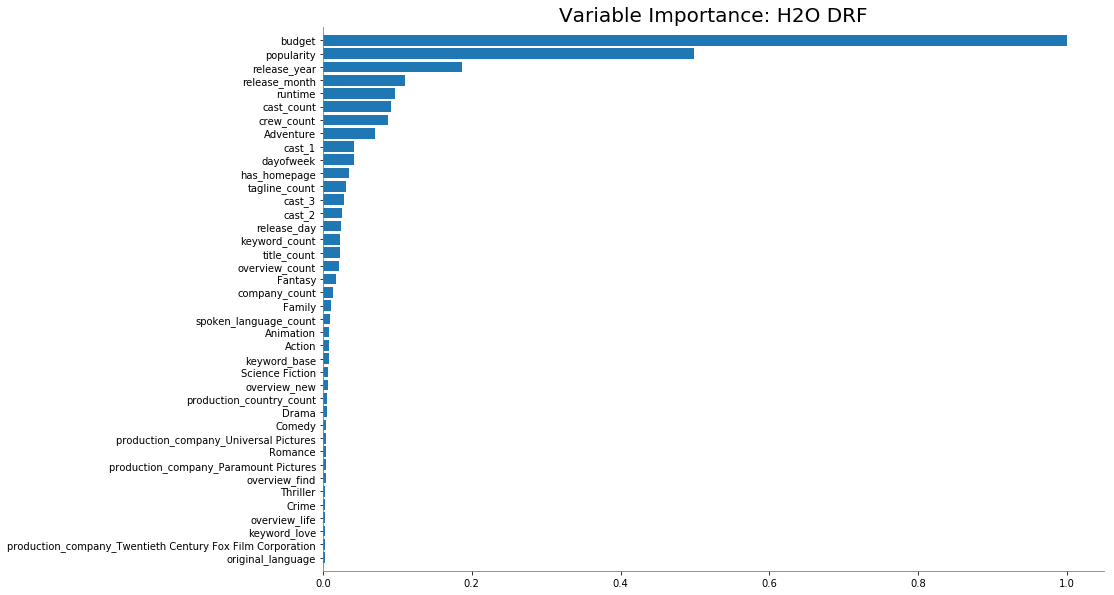

In [539]:
revenue_rf.varimp_plot(40)

In [540]:
# define the top 40 important variables for other model
X2 = []
for i in range(0,40):
    X2.append(revenue_rf.varimp()[0:40][i][0])

In [541]:
# train the second model with top 40 variables
revenue_rf2 = H2ORandomForestEstimator(
    model_id="rf2",
    ntrees=500,
    stopping_rounds=20,
    score_each_iteration=True,
    nfolds = 10,
    seed=12345)
revenue_rf2.train(X2, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [542]:
print(revenue_rf2.r2())
print(revenue_rf2.r2(valid = True))

0.6617068934629196
0.6374838130348526


#### GBM model

In [543]:
# initialize second grid search with all variables
import math

hyper_parameters = {'ntrees':list(range(0, 500, 10)),
                    'max_depth':list(range(0, 20, 1)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate' : [x/100. for x in range(20,101)],
                    'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                    'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                    'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                    'min_split_improvement': [0,1e-8,1e-6,1e-4]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':600,
                   'seed' : 12345,
                   'stopping_metric': "deviance"}

# initialize grid search
gsearch1 = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search with all the variable
gsearch1.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid,
              seed = 12345)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate, 0.43
Hyper-parameter: col_sample_rate_change_per_level, 0.97
Hyper-parameter: col_sample_rate_per_tree, 0.87
Hyper-parameter: max_depth, 0
Hyper-parameter: min_rows, 1.0
Hyper-parameter: min_split_improvement, 0.0001
Hyper-parameter: ntrees, 230
Hyper-parameter: sample_rate, 0.9
failure_details: Illegal argument(s) for GBM model: Grid_GBM_py_1536_sid_8216_model_python_1557417861413_1_model_2.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: Grid_GBM_py_1536_sid_8216_model_python_1557417861413_1_model_2.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.gbm.

In [544]:
# show grid search results
gsearch1.show()

# select best model
gbm1_model = gsearch1.get_grid()[0]

# print model information
gbm1_model

     col_sample_rate col_sample_rate_change_per_level  \
0               0.24                             0.91   
1               0.41                             1.03   
2                0.4                              0.9   
3               0.36                             0.97   
4               0.33                             0.98   
5               0.58                              0.9   
6               0.53                             0.95   
7                0.7                              1.0   
8               0.45                             1.02   
9               0.56                             1.05   
10              0.39                             0.99   
11              0.46                             1.01   
12              0.87                             0.99   
13              0.35                             0.96   
14              0.87                             0.96   
15              0.98                              1.1   
16              0.42           

46    0.721237226281499  
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_1536_sid_8216_model_python_1557417861413_1_model_30


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.15351316602626922
RMSE: 0.3918075624924425
MAE: 0.214876428180286
RMSLE: 0.26113632143200727
Mean Residual Deviance: 0.15351316602626922

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.3512770881174668
RMSE: 0.592686331981316
MAE: 0.3484322694896886
RMSLE: 0.40889611544360027
Mean Residual Deviance: 0.3512770881174668
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-05-09 12:07:07,1 min 24.909 sec,0.0,0.9997923,0.5549241,0.9995845,0.9991565,0.6052775,0.9983137
,2019-05-09 12:07:07,1 min 24.920 sec,1.0,0.9758396,0.5370601,0.9522630,0.9787457,0.5888786,0.9579432
,2019-05-09 12:07:07,1 min 24.925 sec,2.0,0.9323297,0.5095354,0.8692386,0.9241525,0.5599449,0.8540578
,2019-05-09 12:07:07,1 min 24.929 sec,3.0,0.9283179,0.5059808,0.8617741,0.9209962,0.5577352,0.8482340
,2019-05-09 12:07:07,1 min 24.935 sec,4.0,0.8849163,0.4843739,0.7830768,0.8732564,0.5344430,0.7625767
---,---,---,---,---,---,---,---,---,---
,2019-05-09 12:07:07,1 min 25.480 sec,116.0,0.3972983,0.2190863,0.1578459,0.5937297,0.3488393,0.3525149
,2019-05-09 12:07:07,1 min 25.485 sec,117.0,0.3969490,0.2187633,0.1575685,0.5935770,0.3486941,0.3523336
,2019-05-09 12:07:07,1 min 25.490 sec,118.0,0.3964106,0.2186420,0.1571414,0.5935892,0.3486820,0.3523481
,2019-05-09 12:07:07,1 min 25.496 sec,119.0,0.3957239,0.2183563,0.1565974,0.5921446,0.3478878,0.3506352



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
budget,2196.4555664,1.0,0.2566579
popularity,1157.5377197,0.5270026,0.1352594
crew_count,1026.5412598,0.4673626,0.1199523
release_year,606.1412964,0.2759634,0.0708282
runtime,537.3538818,0.2446459,0.0627903
---,---,---,---
tagline_stori,0.5370525,0.0002445,0.0000628
keyword_woman,0.4315782,0.0001965,0.0000504
Music,0.0386293,0.0000176,0.0000045
Foreign,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [545]:
print(gbm1_model.r2(train=True))
print(gbm1_model.r2(valid=True))

0.8464230297314594
0.6481295359134125


In [546]:
# initialize second grid search with top 40 variables
gsearch2 = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)
# execute training w/ grid search with top 40 variables
gsearch2.train(x=X2,
              y=y,
              training_frame=train,
              validation_frame=valid,
              seed = 12345)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate, 0.43
Hyper-parameter: col_sample_rate_change_per_level, 0.97
Hyper-parameter: col_sample_rate_per_tree, 0.87
Hyper-parameter: max_depth, 0
Hyper-parameter: min_rows, 1.0
Hyper-parameter: min_split_improvement, 0.0001
Hyper-parameter: ntrees, 230
Hyper-parameter: sample_rate, 0.9
failure_details: Illegal argument(s) for GBM model: Grid_GBM_py_1536_sid_8216_model_python_1557417861413_2_model_2.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: Grid_GBM_py_1536_sid_8216_model_python_1557417861413_2_model_2.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.gbm.

In [547]:
# show grid search results
gsearch2.show()

# select best model
gbm2_model = gsearch2.get_grid()[0]

# print model information
gbm2_model

     col_sample_rate col_sample_rate_change_per_level  \
0               0.39                             0.99   
1               0.36                             0.97   
2               0.24                             0.91   
3                0.7                              1.0   
4               0.58                              0.9   
5               0.45                             1.02   
6                0.4                              0.9   
7               0.42                             1.06   
8               0.53                             0.93   
9               0.41                             1.03   
10              0.46                             1.01   
11              0.56                             1.05   
12              0.53                             0.95   
13               0.9                             1.06   
14              0.59                             1.03   
15              0.33                             0.98   
16              0.75           

46   0.7214257780172729  
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_1536_sid_8216_model_python_1557417861413_2_model_18


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.0878629676077879e-13
RMSE: 3.298276773722587e-07
MAE: 1.8160703147428384e-07
RMSLE: 3.5302515321830223e-07
Mean Residual Deviance: 1.0878629676077879e-13

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.34448066775268826
RMSE: 0.5869247547622167
MAE: 0.3293248406437454
RMSLE: 0.37747488153488634
Mean Residual Deviance: 0.34448066775268826
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-05-09 12:08:19,33.089 sec,0.0,0.9997923,0.5549241,0.9995845,0.9991565,0.6052775,0.9983137
,2019-05-09 12:08:19,33.119 sec,1.0,0.9225991,0.5099718,0.8511891,0.9418974,0.5680832,0.8871708
,2019-05-09 12:08:19,33.147 sec,2.0,0.8542870,0.4694424,0.7298063,0.8890650,0.5345146,0.7904366
,2019-05-09 12:08:19,33.169 sec,3.0,0.7855146,0.4302741,0.6170333,0.8369072,0.5040748,0.7004136
,2019-05-09 12:08:19,33.186 sec,4.0,0.7214920,0.3960054,0.5205506,0.8030513,0.4810057,0.6448914
---,---,---,---,---,---,---,---,---,---
,2019-05-09 12:08:23,37.034 sec,231.0,0.0001646,0.0001030,0.0000000,0.5869244,0.3293244,0.3444803
,2019-05-09 12:08:23,37.052 sec,232.0,0.0001591,0.0000998,0.0000000,0.5869258,0.3293243,0.3444819
,2019-05-09 12:08:23,37.070 sec,233.0,0.0001545,0.0000972,0.0000000,0.5869255,0.3293238,0.3444815
,2019-05-09 12:08:23,37.082 sec,234.0,0.0001508,0.0000949,0.0000000,0.5869257,0.3293242,0.3444818



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
budget,4130.7832031,1.0,0.3685642
popularity,1306.8886719,0.3163779,0.1166056
release_year,1108.4744873,0.2683449,0.0989023
crew_count,640.8515015,0.1551404,0.0571792
release_month,621.4571533,0.1504454,0.0554488
---,---,---,---
overview_new,13.0514746,0.0031596,0.0011645
original_language,12.8605680,0.0031133,0.0011475
production_company_Twentieth Century Fox Film Corporation,11.4516964,0.0027723,0.0010218
keyword_love,5.9903121,0.0014502,0.0005345



See the whole table with table.as_data_frame()


In [548]:
print(gbm2_model.r2(train=True))
print(gbm2_model.r2(valid=True))

0.9999999999998912
0.6549374367665488


---

#### Penalized Regression

In [549]:
# train the variable with all the variables
revenue_regression = H2OGeneralizedLinearEstimator(family='gaussian',
                                         model_id='revenue_regression1',
                                         solver='IRLSM',
                                         lambda_search=True,
                                         seed =12345, nfolds=10)

# train 
revenue_regression.train(X, y, training_frame=train, validation_frame = valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [550]:
# print trained model info

revenue_regression.model_performance()


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.3536168399243438
RMSE: 0.5946569094228569
MAE: 0.31940032857370976
RMSLE: 0.37159799543687744
R^2: 0.6462361873103244
Mean Residual Deviance: 0.3536168399243438
Null degrees of freedom: 2406
Residual degrees of freedom: 2378
Null deviance: 2406.0000010361
Residual deviance: 851.1557336978955
AIC: 4388.594129254049


In [551]:
print(revenue_regression.r2())
print(revenue_regression.r2(valid=True))

0.6462361873103244
0.6020213651922457


In [552]:
# train the variable with top 40 variables
revenue_regression2 = H2OGeneralizedLinearEstimator(family='gaussian',
                                         model_id='revenue_regression2',
                                         solver='IRLSM',
                                         lambda_search=True,
                                         seed =12345, nfolds=10)

# train 
revenue_regression2.train(X2, y, training_frame=train, validation_frame = valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [553]:
# print trained model info

revenue_regression2.model_performance()


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.354155599577635
RMSE: 0.5951097374246492
MAE: 0.3196506130820795
RMSLE: 0.37159111029435793
R^2: 0.6456972037338848
Mean Residual Deviance: 0.354155599577635
Null degrees of freedom: 2406
Residual degrees of freedom: 2379
Null deviance: 2406.0000010361
Residual deviance: 852.4525281833673
AIC: 4390.258569019047


In [554]:
print(revenue_regression2.r2())
print(revenue_regression2.r2(valid=True))

0.6456972037338848
0.6013889895668523


----

#### Multi Layer Perceptron

In [555]:
# train the mlp with all the variables
# define random grid search parameters
hyper_parameters_mlp1 = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria_mlp1 = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':600,'seed':12345}

# initialize grid search
gsearch_mlp1 = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters_mlp1,
                        search_criteria=search_criteria_mlp1)

In [556]:
gsearch_mlp1.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid,seed = 12345)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: hidden, [50, 50, 50, 50]
Hyper-parameter: input_dropout_ratio, 0.02
Hyper-parameter: l1, 0.04
Hyper-parameter: l2, 0.008
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exp


Hyper-parameter: hidden, [320, 160, 80]
Hyper-parameter: input_dropout_ratio, 0.14
Hyper-parameter: l1, 0.06
Hyper-parameter: l2, 0.002
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a diff


Hyper-parameter: hidden, [80, 190]
Hyper-parameter: input_dropout_ratio, 0.02
Hyper-parameter: l1, 0.07
Hyper-parameter: l2, 0.004
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different


Hyper-parameter: hidden, [50, 50, 50, 50]
Hyper-parameter: input_dropout_ratio, 0.1
Hyper-parameter: l1, 0.08
Hyper-parameter: l2, 0.009
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a dif


Hyper-parameter: hidden, [320, 160, 80]
Hyper-parameter: input_dropout_ratio, 0.18
Hyper-parameter: l1, 0.05
Hyper-parameter: l2, 0.002
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a diff

In [557]:
# select best model
mlp1_model = gsearch_mlp1.get_grid()[0]

# print model information
mlp1_model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  Grid_DeepLearning_py_1536_sid_8216_model_python_1557417861413_3_model_33


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.16400603637618738
RMSE: 0.4049765874420241
MAE: 0.24461750208834263
RMSLE: 0.2940102650327919
Mean Residual Deviance: 0.16400603637618738

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.35102139995555554
RMSE: 0.5924705899498772
MAE: 0.3745830040312672
RMSLE: 0.41941085675298306
Mean Residual Deviance: 0.35102139995555554
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2019-05-09 12:13:02,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2019-05-09 12:13:02,3 min 19.680 sec,9589 obs/sec,1.0,1,2407.0,0.5872571,0.3448709,0.3224890,0.6549857,0.6512828,0.4241693,0.3675903,0.5751142
,2019-05-09 12:13:05,3 min 22.240 sec,9521 obs/sec,10.0,10,24070.0,0.4049766,0.1640060,0.2446175,0.8359258,0.5924706,0.3510214,0.3745830,0.6483857


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
release_year.2017,1.0,1.0,0.0009900
History.1,0.8541274,0.8541274,0.0008456
release_year.2006,0.5838975,0.5838975,0.0005781
release_month.10,0.5579959,0.5579959,0.0005524
has_homepage.0,0.5331296,0.5331296,0.0005278
---,---,---,---
keyword_murder.missing(NA),0.0,0.0,0.0
keyword_love.missing(NA),0.0,0.0,0.0
Animation.missing(NA),0.0,0.0,0.0
Comedy.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [558]:
# measure mlp AUC
print(mlp1_model.r2(train=True))
print(mlp1_model.r2(valid=True))

0.8359257982595651
0.6483856559828292


In [559]:
# train the mlp with top 40 variables
# initialize grid search
gsearch_mlp2 = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters_mlp1,
                        search_criteria=search_criteria_mlp1)

gsearch_mlp2.train(x=X2,
              y=y,
              training_frame=train,
              validation_frame=valid,seed = 12345)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: hidden, [50, 50, 50, 50]
Hyper-parameter: input_dropout_ratio, 0.02
Hyper-parameter: l1, 0.04
Hyper-parameter: l2, 0.008
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exp


Hyper-parameter: hidden, [320, 160, 80]
Hyper-parameter: input_dropout_ratio, 0.14
Hyper-parameter: l1, 0.06
Hyper-parameter: l2, 0.002
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a diff


Hyper-parameter: hidden, [170, 320]
Hyper-parameter: input_dropout_ratio, 0.16
Hyper-parameter: l1, 0.03
Hyper-parameter: l2, 0.008
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a differen


Hyper-parameter: hidden, [80, 190]
Hyper-parameter: input_dropout_ratio, 0.02
Hyper-parameter: l1, 0.07
Hyper-parameter: l2, 0.004
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different


Hyper-parameter: hidden, [50, 50, 50, 50]
Hyper-parameter: input_dropout_ratio, 0.1
Hyper-parameter: l1, 0.08
Hyper-parameter: l2, 0.009
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a dif


Hyper-parameter: hidden, [320, 160, 80]
Hyper-parameter: input_dropout_ratio, 0.18
Hyper-parameter: l1, 0.05
Hyper-parameter: l2, 0.002
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a diff

In [560]:
# select best model
mlp2_model = gsearch_mlp2.get_grid()[0]

# print model information
mlp2_model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  Grid_DeepLearning_py_1536_sid_8216_model_python_1557417861413_4_model_29


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.13961004995539372
RMSE: 0.37364428264780625
MAE: 0.1990406582734881
RMSLE: 0.24218863517960898
Mean Residual Deviance: 0.13961004995539372

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.35905354803381695
RMSE: 0.5992107709594487
MAE: 0.3583661463273981
RMSLE: 0.4175548728646017
Mean Residual Deviance: 0.35905354803381695
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2019-05-09 12:17:16,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2019-05-09 12:17:17,2 min 44.883 sec,3012 obs/sec,1.0,1,2407.0,0.5763297,0.3321559,0.3145144,0.6677061,0.6432169,0.4137279,0.3578818,0.5855732
,2019-05-09 12:17:23,2 min 51.367 sec,4453 obs/sec,10.0,10,24070.0,0.3736443,0.1396100,0.1990407,0.8603319,0.5992108,0.3590535,0.3583661,0.6403399


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
has_homepage.0,1.0,1.0,0.0005318
Adventure.0,0.8534292,0.8534292,0.0004539
Animation.0,0.8429243,0.8429243,0.0004483
dayofweek.4,0.7970437,0.7970437,0.0004239
budget,0.7905109,0.7905109,0.0004204
---,---,---,---
keyword_base.missing(NA),0.0,0.0,0.0
keyword_love.missing(NA),0.0,0.0,0.0
Animation.missing(NA),0.0,0.0,0.0
Comedy.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [561]:
# measure mlp AUC
print(mlp2_model.r2(train=True))
print(mlp2_model.r2(valid=True))

0.8603319243150777
0.6403399400294878


---

### Part 5 Model Comparison & Evaluation

We decide to use R^2 as the benchmark to evaluate each model.

In [562]:
# train and validation score with all the variable
valid_r2 = [revenue_rf.r2(valid = True),gbm1_model.r2(valid = True), revenue_regression.r2(valid = True), \
            mlp1_model.r2(valid = True)]
train_r2 = [revenue_rf.r2(), gbm1_model.r2(),revenue_regression.r2(),mlp1_model.r2()]

In [563]:
# train and validation score with all the variable
r2_df = pd.DataFrame([train_r2,valid_r2], index = ['train set','validation set'], \
                     columns = ['random forest model','gradient boost model','regression','multi layer perceptron'])
r2_df

,random forest model,gradient boost model,regression,multi layer perceptron
train set,0.657086,0.846423,0.646236,0.835926
validation set,0.640389,0.648130,0.602021,0.648386


In [564]:
# train and validation score with top 40 variables
valid_r2_top = [revenue_rf2.r2(valid = True),gbm2_model.r2(valid = True), revenue_regression2.r2(valid = True),\
                mlp2_model.r2(valid = True)]
train_r2_top = [revenue_rf2.r2(),gbm2_model.r2(),revenue_regression2.r2(),mlp2_model.r2()]

In [565]:
# train and validation score with all the variable
r2_df_top = pd.DataFrame([train_r2_top,valid_r2_top], index = ['train set','validation set'], \
                     columns = ['random forest model','gradient boost model','regression','multi layer perceptron'])
r2_df_top

,random forest model,gradient boost model,regression,multi layer perceptron
train set,0.661707,1.000000,0.645697,0.860332
validation set,0.637484,0.654937,0.601389,0.640340


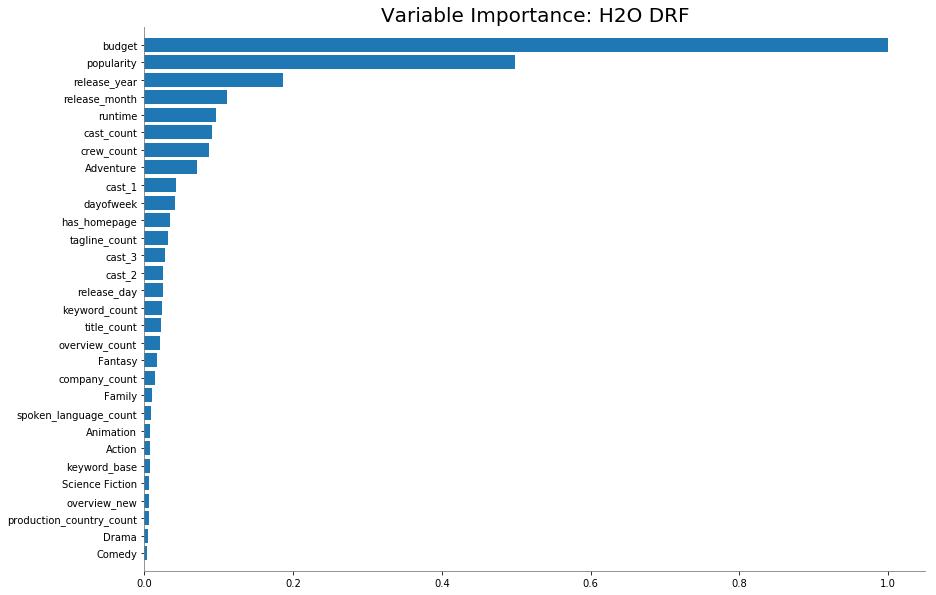

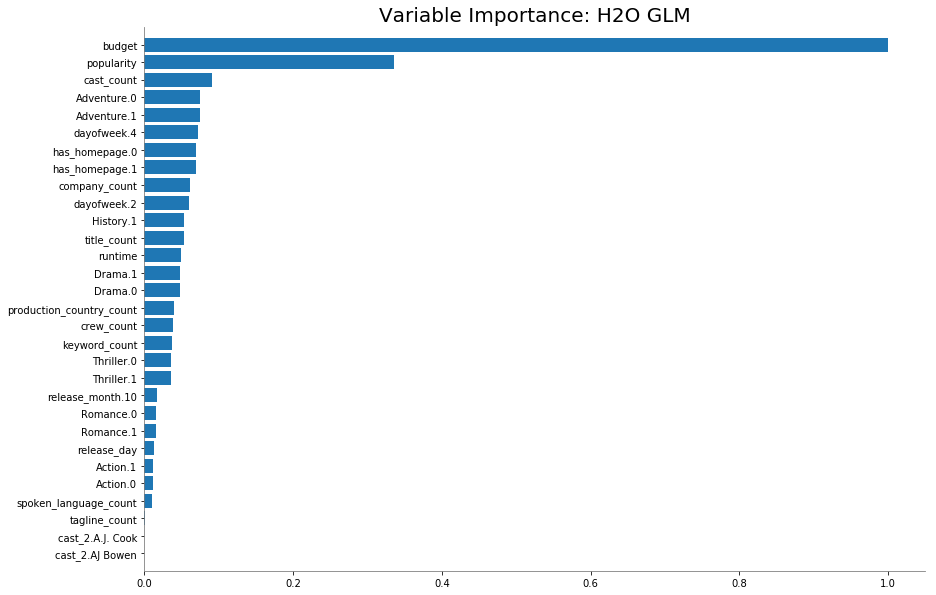

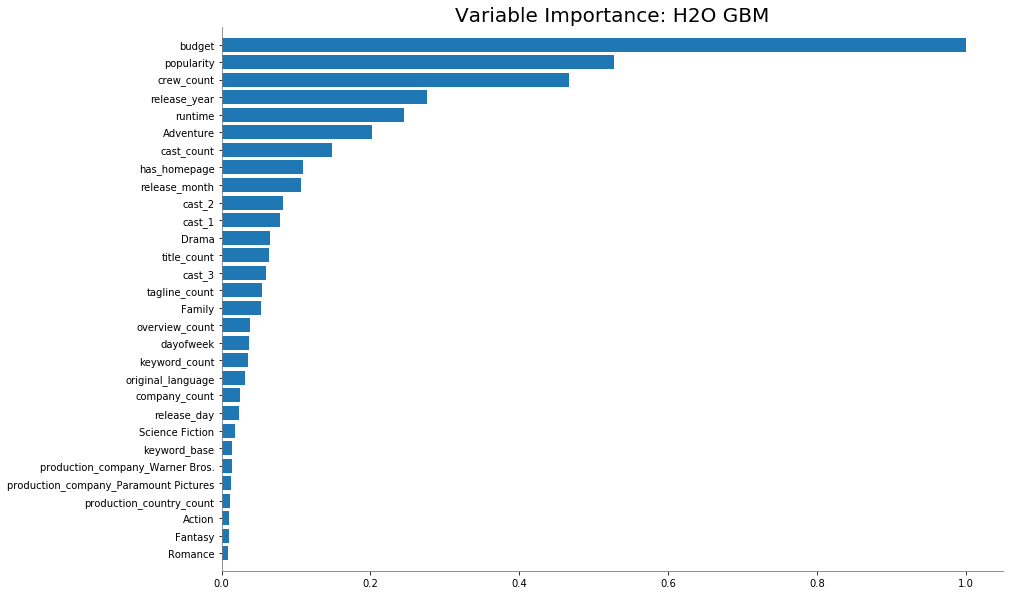

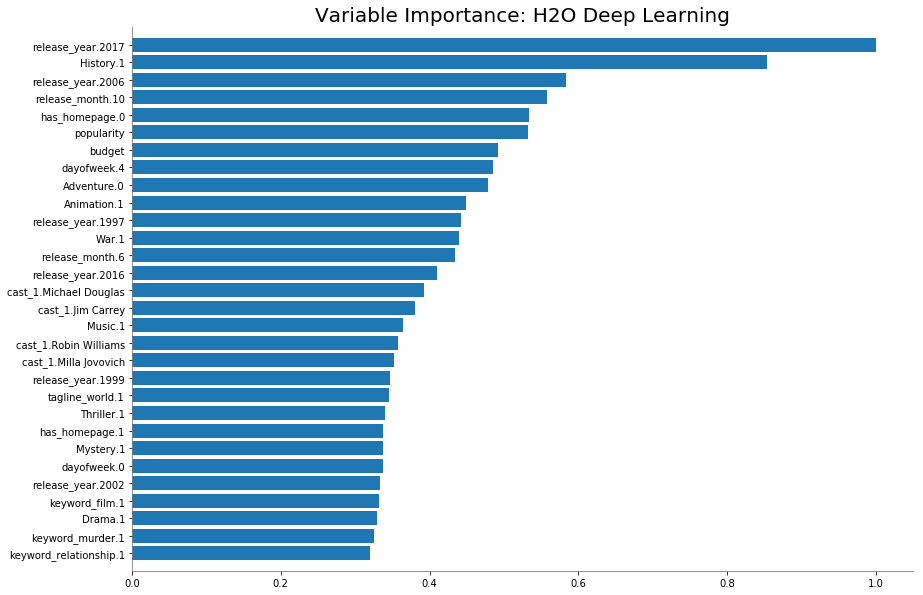

In [566]:
# the variable importance of the four approaches
revenue_rf.varimp_plot(30)
revenue_regression.varimp_plot(30)
gbm1_model.varimp_plot(30)
mlp1_model.varimp_plot(30)

We decide to use random forest model to predict our test set. Before prediction we decide to check the Partial dependence plot and ICE plot for the most important variable budget.

In [567]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = float((max_ - min_))/float(resolution)
        bins = np.arange(min_, max_, by, dtype=float)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |██

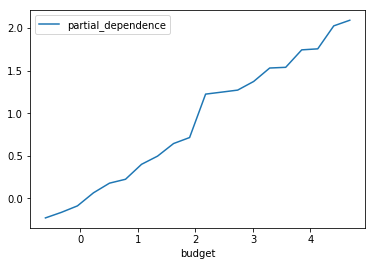

In [568]:
# show some output
par_dep_budget = par_dep('budget', valid, revenue_rf)
par_dep_budget.plot.line(x='budget', y='partial_dependence')
print()
print(par_dep_budget)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model rf1 on column 'budget'



budget,mean_response,stddev_response,std_error_mean_response
-0.6062753,-0.2293242,0.3254625,0.0133651
-0.3132146,-0.1579077,0.3266751,0.0134149
-0.0201538,-0.0747296,0.3227283,0.0132529
0.2729069,0.0771504,0.3376687,0.0138664
0.5659676,0.1801614,0.3748853,0.0153947
0.8590283,0.2612558,0.4250617,0.0174552
1.1520891,0.4634143,0.4464953,0.0183354
1.4451498,0.5273433,0.4776473,0.0196146
1.7382105,0.6717628,0.4776950,0.0196166
2.0312713,0.7227626,0.4990248,0.0204925


[]

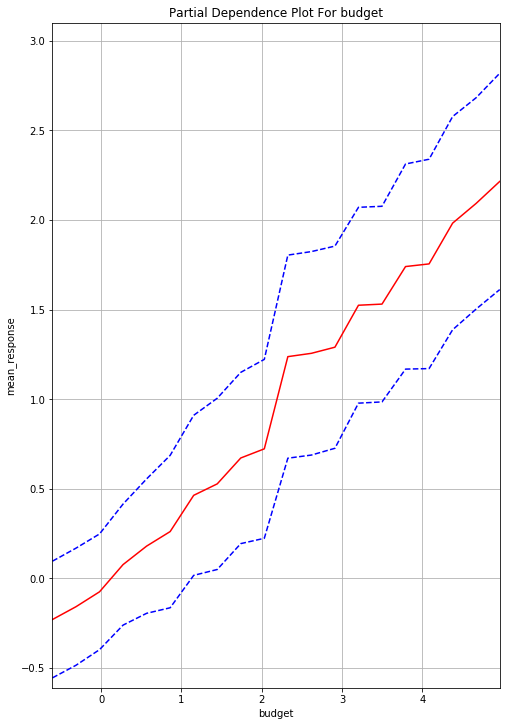

In [569]:
revenue_rf.partial_plot(data=valid, cols=['budget'], plot=True, plot_stddev=True)

In [570]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

quantile_dict = get_quantile_dict('revenue', 'id', valid)

In [571]:
bins = list(par_dep_budget['budget'])
for i in sorted(quantile_dict.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_budget[col_name] = par_dep('budget', valid[valid['id'] == int(quantile_dict[i])], \
                                       revenue_rf, bins=bins)['partial_dependence']
par_dep_budget

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |██

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |██

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |██

,budget,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-0.606275,-0.229324,-0.335002,-0.034214,-0.435445,-0.273531,-0.399765,-0.423174,-0.197200,-0.216270,-0.396111,0.091377,1.362687
1,-0.327868,-0.163787,-0.234907,0.007525,-0.360539,-0.205850,-0.337551,-0.341430,-0.149188,-0.083872,-0.374381,0.104400,1.414762
2,-0.049460,-0.087917,-0.136074,0.026906,-0.290556,-0.052926,-0.265855,-0.275050,-0.022296,-0.014973,-0.282875,0.266989,1.456575
3,0.228948,0.065516,0.022828,0.257156,-0.062969,0.142252,-0.162104,-0.099098,0.032266,0.203016,-0.128434,0.491575,1.784018
4,0.507355,0.178883,0.072610,0.370501,0.025158,0.367520,-0.102063,0.032531,0.164033,0.300101,-0.087068,0.669768,2.111490
5,0.785763,0.224601,0.090377,0.382648,0.013259,0.373441,-0.075558,0.089189,0.200108,0.402130,-0.069998,0.681210,2.486219
6,1.064171,0.400077,0.195969,0.466336,0.099645,0.591041,-0.069584,0.209115,0.460338,0.636542,0.032453,0.908623,2.795657
7,1.342579,0.496282,0.193364,0.605329,0.261793,0.663737,-0.018712,0.263945,0.462272,0.674194,0.139251,0.872874,3.125408
8,1.620986,0.644226,0.249484,0.636388,0.511096,0.817893,0.139320,0.444051,0.603664,0.797633,0.298358,0.896845,3.077610
9,1.899394,0.714525,0.296229,0.678540,0.578339,1.048690,0.207618,0.481068,0.700753,0.859773,0.416903,0.941702,3.069945


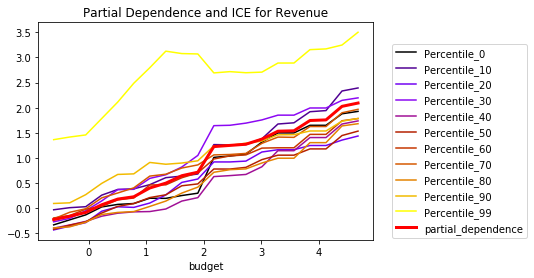

In [572]:
fig, ax = plt.subplots()
par_dep_budget.drop('partial_dependence', axis=1).plot(x='budget', colormap='gnuplot', ax=ax)

par_dep_budget.plot(title='Partial Dependence and ICE for Revenue',
                         x='budget', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.2)

### Part 6 Model Predicting

After look at the the performance of the model we decide to use random forest to predict the test set.

In [97]:
prediction = revenue_rf.predict(test_data = test_frame).as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


D:\Program Files\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'original_language' has levels not trained on: [af, bm, ca, is, ka, kn, th, xx]
  warnings.warn(w)
D:\Program Files\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'release_month' has levels not trained on: [0]
  warnings.warn(w)
D:\Program Files\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'release_year' has levels not trained on: [1922, 1923, 1929, 1934, 1937, 1941, 1946, 2018]
  warnings.warn(w)
D:\Program Files\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'dayofweek' has levels not trained on: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
  warnings.warn(w)
D:\Program Files\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'cast_1' has levels not trained on: [Aaron Paul, Aasif Mandvi, Abbie Cornish, Abhishek Bachchan, Adam Bousdouko

D:\Program Files\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'cast_2' has levels not trained on: [A. Michael Baldwin, Aaran Thomas, Aaron Abrams, Aaron Ruell, Aaron Schwartz, Abbie Cornish, Adam Campbell, Adam G. Sevani, Adam Garcia, Adam Horovitz, Adam Lamberg, Adi Rukun, Adile Na鈮埫糹t, Aditya Roy Kapoor, Adolph Caesar, Adolph Davis, Adrian Grenier, Adrianne Palicki, Adrien Brody, Afemo Omilami, Agnes Bruckner, Aidan Quinn, Aitana S鈭毬皀chez-Gij鈭氣墺n, Ajay Devgn, Akihiro Miwa, Alan Alda, Alan Rickman, Alan Schwarz, Alan Tudyk, Alba Rohrwacher, Alberto San Juan, Alec McCowen, Aleksandr Baluev, Aleksandr Demidov, Aleksandr Domogarov, Aleksey Chadov, Alessandra Negrini, Alessandro Siani, Alex Dobrenko, Alex Gerry, Alex Hyde-White, Alex Jennings, Alex Kendrick, Alex McArthur, Alex Pettyfer, Alex Russell, Alexander Knox, Alexandra Rapaport, Alexandra Roach, Alexie Gilmore, Alexis Bledel, Alexis Zegerman, Alfred Abel, Alfredo Castro, Ali Larter, Ali Ma

D:\Program Files\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: Test/Validation dataset column 'cast_3' has levels not trained on: [A. Michael Baldwin, Aaran Thomas, Aaron Abrams, Aaron Ruell, Aaron Schwartz, Abbie Cornish, Adam Campbell, Adam G. Sevani, Adam Garcia, Adam Horovitz, Adam Lamberg, Adi Rukun, Adile Na鈮埫糹t, Aditya Roy Kapoor, Adolph Caesar, Adolph Davis, Adrian Grenier, Adrianne Palicki, Adrien Brody, Afemo Omilami, Agnes Bruckner, Aidan Quinn, Aitana S鈭毬皀chez-Gij鈭氣墺n, Ajay Devgn, Akihiro Miwa, Alan Alda, Alan Rickman, Alan Schwarz, Alan Tudyk, Alba Rohrwacher, Alberto San Juan, Alec McCowen, Aleksandr Baluev, Aleksandr Demidov, Aleksandr Domogarov, Aleksey Chadov, Alessandra Negrini, Alessandro Siani, Alex Dobrenko, Alex Gerry, Alex Hyde-White, Alex Jennings, Alex Kendrick, Alex McArthur, Alex Pettyfer, Alex Russell, Alexander Knox, Alexandra Rapaport, Alexandra Roach, Alexie Gilmore, Alexis Bledel, Alexis Zegerman, Alfred Abel, Alfredo Castro, Ali Larter, Ali Ma

In [98]:
prediction.head(5)

,predict
0,-0.271418
1,-0.449404
2,-0.384534
3,-0.267561
4,-0.438522


In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
revenue = train_frame['revenue'].as_data_frame()
scaler.fit(revenue)
prediction['predict'] = scaler.inverse_transform(prediction['predict'])

In [110]:
submission = test_frame['id'].as_data_frame()
submission = pd.concat([submission,prediction],axis=1)

In [111]:
submission.head()

,id,predict
0,3001,2.940338e+07
1,3002,4.928575e+06
2,3003,1.384886e+07
3,3004,2.993372e+07
4,3005,6.424911e+06


In [112]:
submission.to_csv('submission.csv', index=False)

In [423]:
h2o.cluster().shutdown()

H2O session _sid_9484 closed.


We upload the predicted set to Kaggle and got the 763/984. 
Then we try to use log to transform revenue and get 500/984. Although using log transformation, the R square is lower than the scaled form, the rank is higher in Kaggle.
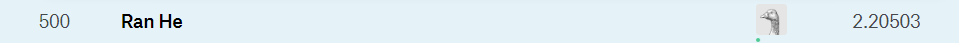